In [1]:
# Goal of this notebook is to implement the dynamical model of Neggers et al. (2006).
# Figure 4 of Neggers et al. (2006) is reproduced, but the equilibrium values do not coincide with theirs.
# They coincide with those published by Youtong Zheng here https://github.com/youtongzheng/Neggers_2006.

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')

## these files contain all functions definiing bulk model, saturation humidities, LCL ...
import neggers_2006
import neggers_stevens

In [2]:
%load_ext autoreload
%autoreload 2

# Neggers et al. (2006) model

The model numerically solves the following three equations for the ABL height $h$, total specific humidity $q_t$ and liquid water potential temperature $\theta_l$
$$ \frac{\partial h}{\partial t} = E + w - M $$
$$ h\frac{\partial q_t}{\partial t} = \overline{w'q_t'}_s + E \Delta q_t + hF_{adv,q_t} $$
$$ h\frac{\partial \theta_l}{\partial t} = \overline{w'\theta_l'}_s + E\Delta\theta_l + hF_{adv,\theta_l} + hF_{rad}, $$
where the surface fluxes are represented with the bulk formulae
$$\overline{w'q_t'}_s = |\boldsymbol{u}_s|C_q^s(q_t^s-q_t)$$
$$\overline{w'\theta_l'}_s = |\boldsymbol{u}_s|C_\theta^s(\theta_l^s-\theta_l)$$
with  $C_q^s = C_\theta^s = 0.0012$, $\boldsymbol{u}_s$ being the surface wind and $q_t^s$ and $\theta_l^s$ the surface properties. The symbol $\Delta$ denotes the jump across the transition layer and not the difference between the free atmosphere and ABL values.

Remind that the liquid water potential temperature can be approximated with 
$$ \theta_l = \theta - \frac{L_v}{c_{pd}}r_l,$$
with $L_v$ the latent heat of vaporization, $c_{pd}$ the specific heat of dry air at constant pressure and $r_l$ the liquid water mixing ratio.

Starting from the equation for $h$, the entrainment $E$ has the units of a velocity and it appears in the virtual potential temperature flux at the ABL top as
$$\overline{w'\theta_v'}_h = E\Delta\theta. $$
From the definition of virtual potential temperature, $\theta_v = \theta(1+0.61q_t-1.61q_l)$, assuming no liquid water, $q_l = 0$, the jump in $\theta_v$ at the ABL top can be explicitly written as
$$\Delta\theta_v = \Delta\theta+ 0.61(\theta\Delta q_t+q_t\Delta\theta+\Delta q_t\Delta\theta).$$

The transition layer jumps are related to the difference w.r.t. the free atmospheric values with some transfer coefficients that represent the cloud layer
$$\Delta q_t = C_q^c (q_t^+-q_t)$$
$$\Delta \theta_l = C_\theta^c (\theta_l^+-\theta_l),$$
with $C_q^c = 0.1$ and $C_\theta^c = 0.03$ from LES hourly mean profiles.

Similarly, the link between the virtual potential temperature flux and the other fluxes is 
$$\overline{w'\theta_v'} = (1+0.61q_t)\overline{w'\theta_l'} + 0.61\theta\overline{w'q_t'}$$
(Cuijpers and Betchold, 1995), neglecting the liquid water specific humidity term.

But the ABL top virtual potential temperature flux has been shown to be proportional to the surface virtual potential temperature flux as
$$ \overline{w'\theta_v'}_h = -0.2 \overline{w'\theta_v'}_s. $$
Thus, the entrainment can be written as 
$$ E = 0.2\frac{\overline{w'\theta_v'}_s}{\Delta\theta_v} $$

The vertical velocity at the ABL top, $w$, is easily imposed as a boundary condition, knowing the large scale subsidence $D$, through mass conservation, namely
$$ w = -hD .$$

The mass flux term $M$ is parameterized as the product of a vertical velocity scale, which has been identified with the Deardorff convective velocity scale $w_*$, and a fractional area of shallow convection $a_c$. Thus,
$$ M = a_cw_*,$$
with 
$$ w_* = (h\overline{w'b'}_s)^{1/3}, $$
$\overline{w'b'}_s = g\overline{w'\theta_v'}_s/\theta_v$ being the surface buoyancy flux. The moist convective area fraction is written as a function of the normalized saturation deficit at the ABL top, namely
$$a_c = 0.5 + 0.36 \arctan\left(1.55\frac{q_t-q_{sat}}{\sigma_q}\right),$$
where $q_{sat}$ is the saturation specific humidity at the ABL top and $\sigma_q^2$, the specific humidity turbulent variance at the ABL top, can be expressed as
$$ \sigma_q^2 = -\frac{h}{w_*}\frac{\Delta q_t}{\Delta z}\overline{w'q_t'}_s.$$
$\Delta z=100$ m is the estimated depth of the cloud transition layer.

In [3]:
# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_2006.qsea(SST-273.15,ps)*1e-3
q_BL = q_s - q_free   # initial BL moisture; Ale added, 6th Feb 2025

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
ps = 1015 # [hPa], surface pressure

# initial conditions vector  
y0 = [100,q_BL,th_s-2]     

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0

dict_ext_N06 = {'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], \
                    'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[], 'sigma_q_ext':[], 'SHF_ext':[], 'LCL_ext':[] }
sol_N06 = solve_ivp(neggers_2006.neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps, dict_ext_N06))#, t_eval=t_eval)

equilibrium h = 557.85 m
equilibrium LCL = 734.42 m
equilibrium q = 16.04 g/kg
equilibrium th = 299.17 K
equilibrium a$_c$ = 8.01%
equilibrium w$\star$ = 0.6 m/s


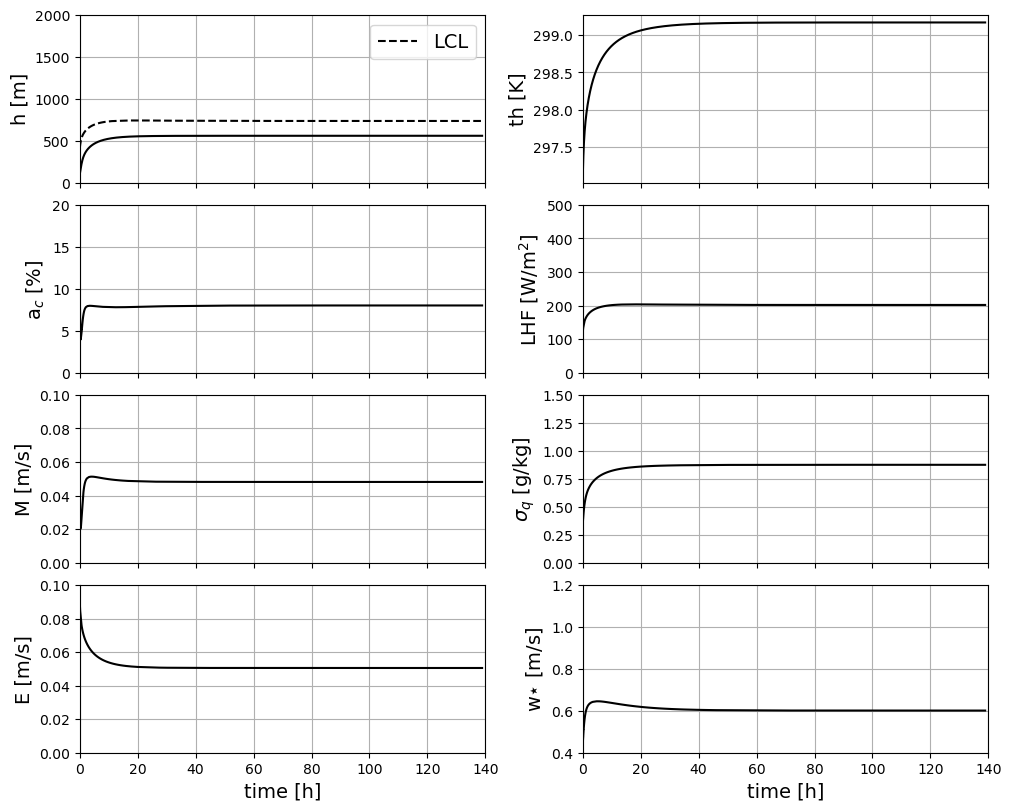

In [4]:
# Plots for a single run.
h = sol_N06.y[0]
q = sol_N06.y[1]
th = sol_N06.y[2]

q_s = neggers_2006.qsea(SST-273.15,ps) # [kg/kg], surface total specific humidity (saturation value)
eq_T0 = th[-1]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
eq_LCL = neggers_2006.lcl(ps*100,eq_T0,q[-1]*1e3/q_s)

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_N06 = np.max(sol_N06.t)
dt_N06 = t_final_N06/3600/len(dict_ext_N06['E_ext']) # [h]
time_ext_N06 = np.arange(len(dict_ext_N06['E_ext']))*dt_N06

print('equilibrium h = '+str(round(h[-1],2))+' m')
print('equilibrium LCL = '+str(round(eq_LCL,2))+' m')
print('equilibrium q = '+str(round(q[-1]*1e3, 2))+' g/kg')
print('equilibrium th = ' +str(round(th[-1], 2))+' K')
print('equilibrium a$_c$ = '+str(round(dict_ext_N06['area_c_ext'][-1]*100, 2))+'%')
print('equilibrium w$\star$ = '+str(round(dict_ext_N06['w_star_ext'][-1],2))+' m/s')

fig, ax = plt.subplots(4,2,figsize=(10,8),sharex=True,constrained_layout=True)

ax[0,0].plot(sol_N06.t/3600,h,'k')
ax[0,0].plot(time_ext_N06,dict_ext_N06['LCL_ext'],'--k',label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend(fontsize=14)

# ax[0,1].plot(sol_N06.t/3600,q*1e3,'k')
# ax[0,1].plot(time_ext_N06,np.array(dict_ext_N06['qs_ext'])*1e3,'-.k',label='q*$_s$')
# ax[0,1].plot(time_ext_N06,np.array(dict_ext_N06['qsat_ext'])*1e3,'--k',label='q*$_h$')
# ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,1].set_ylim(0,25)
# ax[0,1].grid()
# ax[0,1].legend(fontsize=14)

ax[0,1].plot(sol_N06.t/3600,th,'k')
ax[0,1].set_ylabel('th [K]',fontsize=14)
# ax[0,1].xlabel('time [h]',fontsize=14)
ax[0,1].grid()
# ax[0,1].show()

ax[1,0].plot(time_ext_N06,np.array(dict_ext_N06['area_c_ext'])*100,'k')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext_N06,np.array(dict_ext_N06['LHF_ext']),'k')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext_N06,np.array(dict_ext_N06['M_ext']),'k')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext_N06,np.array(dict_ext_N06['sigma_q_ext'])*1e3,'k')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext_N06,np.array(dict_ext_N06['E_ext']),'k')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext_N06,np.array(dict_ext_N06['w_star_ext']),'k')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(0,140)
ax[3,1].set_xlim(0,140)

# Define the variables with constant V(_mag), CV
h_CV = h
q_CV = q
area_c_ext_CV = dict_ext_N06['area_c_ext']
LHF_ext_CV = dict_ext_N06['LHF_ext']
M_ext_CV = dict_ext_N06['M_ext']
sigma_q_ext_CV = dict_ext_N06['sigma_q_ext']
E_ext_CV = dict_ext_N06['E_ext']
w_star_ext_CV = dict_ext_N06['w_star_ext']

In [18]:
th_s

299.12461778927917

In [6]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3                   # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67                    # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                        # J/K/kg, dry air gas constant
SST = 300.4                       # K
ps = 1015                         # [hPa], surface pressure
ref_p = 1000                      # [hPa], reference pressure for the potential temperature
th_s = SST*(ref_p/ps)**(Rd/cpd)   # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_2006.qsea(SST-273.15,ps)*1e-3

y0 = [100,q_s - q_free,th_s-2]

# Input parameters
V = 8.75         # [m/s], large scale horizontal wind
SST = 300.4      # [K], sea surface temperature
D = 4.3e-6       # [1/s], large scale divergence
q_free = 4.0e-3  # [kg/kg] free tropospheric total mixing ratio
th_free = 308    # [K], free tropospheric liquid virtual potential temperature
ps = 1015        # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing values...
V_N06 = 8.75                          # [m/s], large scale horizontal wind
SST_N06 = 300.4                       # [K], sea surface temperature
D_N06 = 4.3e-6                        # [1/s], large scale divergence
q_free_N06 = 4.0e-3                   # [kg/kg] free tropospheric total mixing ratio
th_free_N06 = 308                     # [K], free tropospheric liquid virtual potential temperature
ps_N06 = 1015                         # [hPa], surface pressure
q_s_N06 = neggers_2006.qsea(SST_N06-273.15,ps_N06)*1e-3


# ... and equilibrium values
h_N06 = 692               # m
q_N06 = 15                # g/kg 
a_c_N06 = 4.3             # %
w_star_N06 = 0.75         # m/s
M_N06 = 0.032             # m/s

# Set a single parameter to change. Remember to change the name of the variable in the following for loop.
# str_variable = 'V'; list_of_values = np.arange(5,15,1); str_units = 'm/s'; x_N06 = V_N06
# str_variable = 'SST'; list_of_values = np.arange(300,310,0.5); str_units = 'K'; x_N06 = SST_N06
#str_variable = 'D'; list_of_values = np.arange(2.5,6.5,0.25)*1e-6; str_units = '1/s'; x_N06 = D_N06
#str_variable = 'q_free'; list_of_values = np.arange(2.0e-3,4.0e-3,0.2e-3); str_units = 'kg/kg'; x_N06 = q_free_N06
#str_variable = 'th_free'; list_of_values = np.arange(302,312); str_units = 'K'; x_N06 = th_free_N06
#str_variable = 'ps'; list_of_values = np.arange(1000,1030,5); str_units = 'hPa'; x_N06 = ps_N06


dict_params = {
        'SST': {'values': np.arange(300,310,0.5), 'units': 'K', 'forcing_N06': SST_N06},
        'V': {'values': np.arange(5,15), 'units': 'm/s', 'forcing_N06': V_N06},
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s', 'forcing_N06': D_N06},
        'q_free': {'values': np.arange(0.5e-3,4.0e-3,0.2e-3), 'units': 'kg/kg', 'forcing_N06': q_free_N06},
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K', 'forcing_N06': th_free_N06},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa', 'forcing_N06': ps_N06}
}

param_of_interest = 'SST'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()

for jj,SST in enumerate(list_of_values):
    ii=0
    
    dict_ext_N06 = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[] }

    sol = solve_ivp(neggers_2006.neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps, dict_ext_N06))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    a_c_eq[jj] = dict_ext_N06['area_c_ext'][-1]
    w_star_eq[jj] = dict_ext_N06['w_star_ext'][-1]
    M_eq[jj] = dict_ext_N06['M_ext'][-1]
    E_eq[jj] = dict_ext_N06['E_ext'][-1]
    LHF_eq[jj] = dict_ext_N06['LHF_ext'][-1]
    LHF_CC_eq[jj] = dict_ext_N06['LHF_CC_ext'][-1]
    qs_eq[jj] = dict_ext_N06['qs_ext'][-1]
    qsat_eq[jj] = dict_ext_N06['qsat_ext'][-1]
    SHF_eq[jj] = dict_ext_N06['SHF_ext'][-1]
    LCL_eq[jj] = dict_ext_N06['LCL_ext'][-1]
    
    print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
    print('---------------------------------------')

5.0 percent
---------------------------------------
10.0 percent
---------------------------------------
15.0 percent
---------------------------------------
20.0 percent
---------------------------------------
25.0 percent
---------------------------------------
30.0 percent
---------------------------------------
35.0 percent
---------------------------------------
40.0 percent
---------------------------------------
45.0 percent
---------------------------------------
50.0 percent
---------------------------------------
55.0 percent
---------------------------------------
60.0 percent
---------------------------------------
65.0 percent
---------------------------------------
70.0 percent
---------------------------------------
75.0 percent
---------------------------------------
80.0 percent
---------------------------------------
85.0 percent
---------------------------------------
90.0 percent
---------------------------------------
95.0 percent
----------------------------------

In [23]:
th_eq

array([298.98310475])

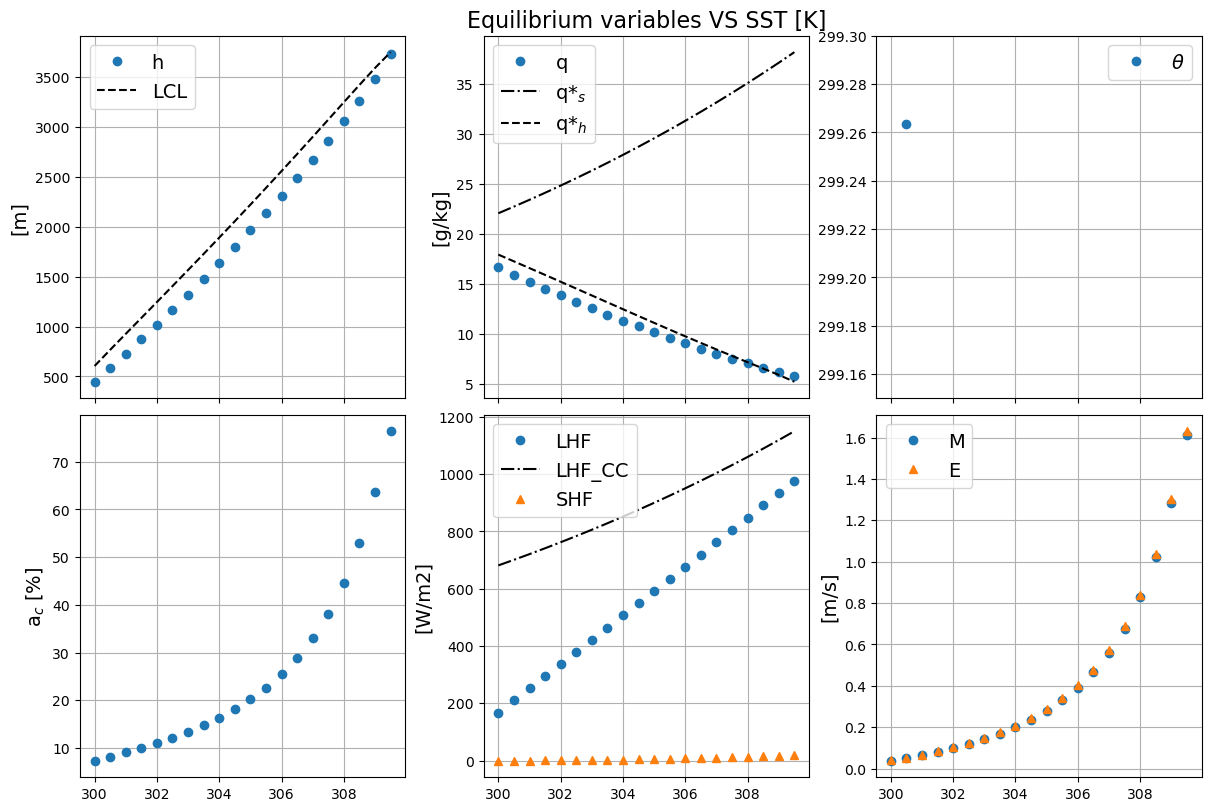

In [7]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].set_ylabel('[m]',fontsize=14)
# ax[0,0].set_title('h and LCL', fontsize=12)
#ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')
ax[0,0].legend(fontsize=14)

ax[0,1].plot(list_of_values,q_eq*1e3,'o',label='q')
ax[0,1].plot(list_of_values,qs_eq*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].set_ylabel('[g/kg]',fontsize=14)
#ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
#ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')
ax[0,1].legend(fontsize=14)

ax[0,2].plot(list_of_values,th_eq,'o', label=r'$\theta$')
ax[0,2].grid()
# ax[0,2].set_ylabel('th [K]',fontsize=14)
#ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)
ax[0,2].set_ylim(299.15, 299.30)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
#ax[1,0].plot(dict_params[param_of_interest]['forcing_N06'],a_c_N06,'kv')

ax[1,1].plot(list_of_values,LHF_eq,'o',label='LHF')
ax[1,1].plot(list_of_values,LHF_CC_eq,'-.k',label='LHF_CC')
ax[1,1].plot(list_of_values,SHF_eq,'^',label='SHF')
ax[1,1].grid()
ax[1,1].set_ylabel('[W/m2]',fontsize=14)
ax[1,1].legend(fontsize=14)

ax[1,2].plot(list_of_values,M_eq,'o',label='M')
ax[1,2].plot(list_of_values,E_eq,'^',label='E')
ax[1,2].grid()
ax[1,2].set_ylabel('[m/s]',fontsize=14)
#ax[1,2].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')

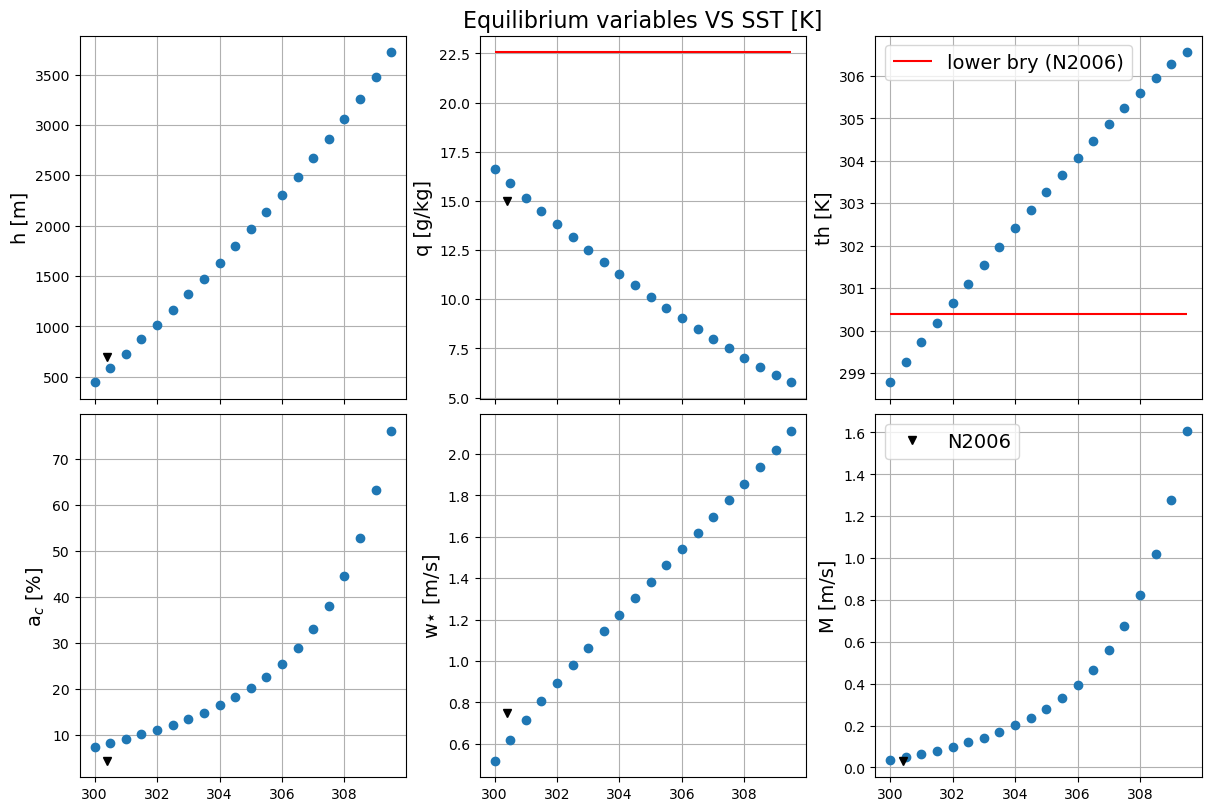

In [15]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o')
ax[0,0].grid()
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')

ax[0,1].plot(list_of_values,q_eq*1e3,'o')
ax[0,1].grid()
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].plot(dict_params[param_of_interest]['forcing_N06'],a_c_N06,'kv')

ax[1,1].plot(list_of_values,w_star_eq,'o')
ax[1,1].grid()
ax[1,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[1,1].plot(dict_params[param_of_interest]['forcing_N06'],w_star_N06,'kv')

ax[1,2].plot(list_of_values,M_eq,'o')
ax[1,2].grid()
ax[1,2].set_ylabel('M [m/s]',fontsize=14)
ax[1,2].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')

##  do cold and warm SST response

In [51]:
#############################   CHOICE OF MODEL FIRST THING FIRST  #################################
# box_model_bool = True
equations_model = neggers_2006.neggers_et_al_2006





#######################  set parameters and initial conditions from here on  #####################

# U_free = -windu # [m/s], free zonal wind (above the ABL).
# V_free = -windv # [m/s], free meridional wind (above the ABL).
# V = np.sqrt(U_free**2 + V_free**2)

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


####  set initial conditions  ####
y0 = [500, q_s - q_free, th_s-3]

    
# Input parameters
V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 301.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 4.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015          # [hPa], surface pressure


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


ii=0

dict_ext_N06_eq = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

## initial unperturbed arguments ##
args_initial = (V, SST_0, D_0, q_free_0, th_free_0, ps_0, dict_ext_N06_eq)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
sol_N06_eq = solve_ivp(equations_model, [0,t_split],  y0, t_eval = t_eval_eq, \
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_N06_eq.y[:,-1]



### concatenate solutions
# t_combined_cold, t_combined_warm = np.concatenate((sol_N06_eq.t, sol_N06_eqPert_cold.t)), np.concatenate((sol_N06_eq.t, sol_N06_eqPert_warm.t))
# y_combined_cold, y_combined_warm = np.hstack((sol_N06_eq.y, sol_N06_eqPert_cold.y)), np.hstack((sol_N06_eq.y, sol_N06_eqPert_warm.y))

In [52]:
dict_ext_N06_eqPert_cold = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , cool SST     ##########
args_modif_cold = (V, SST_0-1, D_0, q_free_0, th_free_0, ps_0, dict_ext_N06_eqPert_cold)

t_eval_cold = np.arange(t_split, max_t, dt_max)

sol_N06_eqPert_cold = solve_ivp(equations_model, [t_split,max_t], y0_split, t_eval = t_eval_cold, \
                               dense_output=True, max_step=dt_max, args=args_modif_cold)
####################   perchè non funziona il fredddo??    #######################àà

In [53]:
dict_ext_N06_eqPert_warm = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , warm SST     ##########
args_modif_warm = (V, SST_0+1, D_0, q_free_0, th_free_0, ps_0, dict_ext_N06_eqPert_warm)

t_eval_warm = np.arange(t_split, max_t, dt_max)

sol_N06_eqPert_warm = solve_ivp(equations_model, [t_split,max_t],  y0_split, t_eval = t_eval_warm, \
                               dense_output=True, max_step=dt_max, args=args_modif_warm)

In [56]:
h_eq, h_cold, h_warm   =  sol_N06_eq.y[0], sol_N06_eqPert_cold.y[0], sol_N06_eqPert_warm.y[0]   ##  y_combined[0]
q_eq, q_cold, q_warm =  sol_N06_eq.y[1], sol_N06_eqPert_cold.y[1], sol_N06_eqPert_warm.y[1]   #y_combined[1]
th_eq, th_cold, th_warm = sol_N06_eq.y[2], sol_N06_eqPert_cold.y[2], sol_N06_eqPert_warm.y[2]   #y_combined[2]
# U_eq, U_cold, U_warm =  sol_N06_eq.y[3], sol_N06_eqPert_cold.y[3], sol_N06_eqPert_warm.y[3]   #y_combined[3]
# V_eq, V_cold, V_warm =  sol_N06_eq.y[4], sol_N06_eqPert_cold.y[4], sol_N06_eqPert_warm.y[4]   #y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_N06_eq, t_final_N06_cold, t_final_N06_warm = np.max(sol_N06_eq.t),\
                                                  np.max(sol_N06_eqPert_cold.t),\
                                                  np.max(sol_N06_eqPert_warm.t)

dt_N06_eq, dt_N06_cold, dt_N06_warm = t_final_N06_eq   / len(dict_ext_N06_eq['E_ext']),\
                                   (t_final_N06_cold - t_final_N06_eq) / len(dict_ext_N06_eqPert_cold['E_ext']),\
                                   (t_final_N06_warm - t_final_N06_eq) / len(dict_ext_N06_eqPert_warm['E_ext']) # [h]

time_ext_N06_eq   = np.arange(len(dict_ext_N06_eq['E_ext']))* dt_N06_eq
time_ext_N06_cold = np.arange(len(dict_ext_N06_eqPert_cold['E_ext']), len(dict_ext_N06_eqPert_cold['E_ext']) / factor_time) * dt_N06_cold
time_ext_N06_warm = np.arange(len(dict_ext_N06_eqPert_warm['E_ext']), len(dict_ext_N06_eqPert_warm['E_ext']) / factor_time) * dt_N06_warm

# print('equilibrium h = '+str(h[-1])+' m')
# print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
# print('equilibrium th = ' +str(th[-1])+' K')
# print('equilibrium a$_c$ = '+str(dict_ext_N06_eqPert['area_c_ext'][-1]*100)+'%')
# print('equilibrium w$^*$ = '+str(dict_ext_N06_eqPert['w_star_ext'][-1])+' m/s')

/venus/tesi_ale/img_bulk/SST_PlusMinus1_N06.pdf


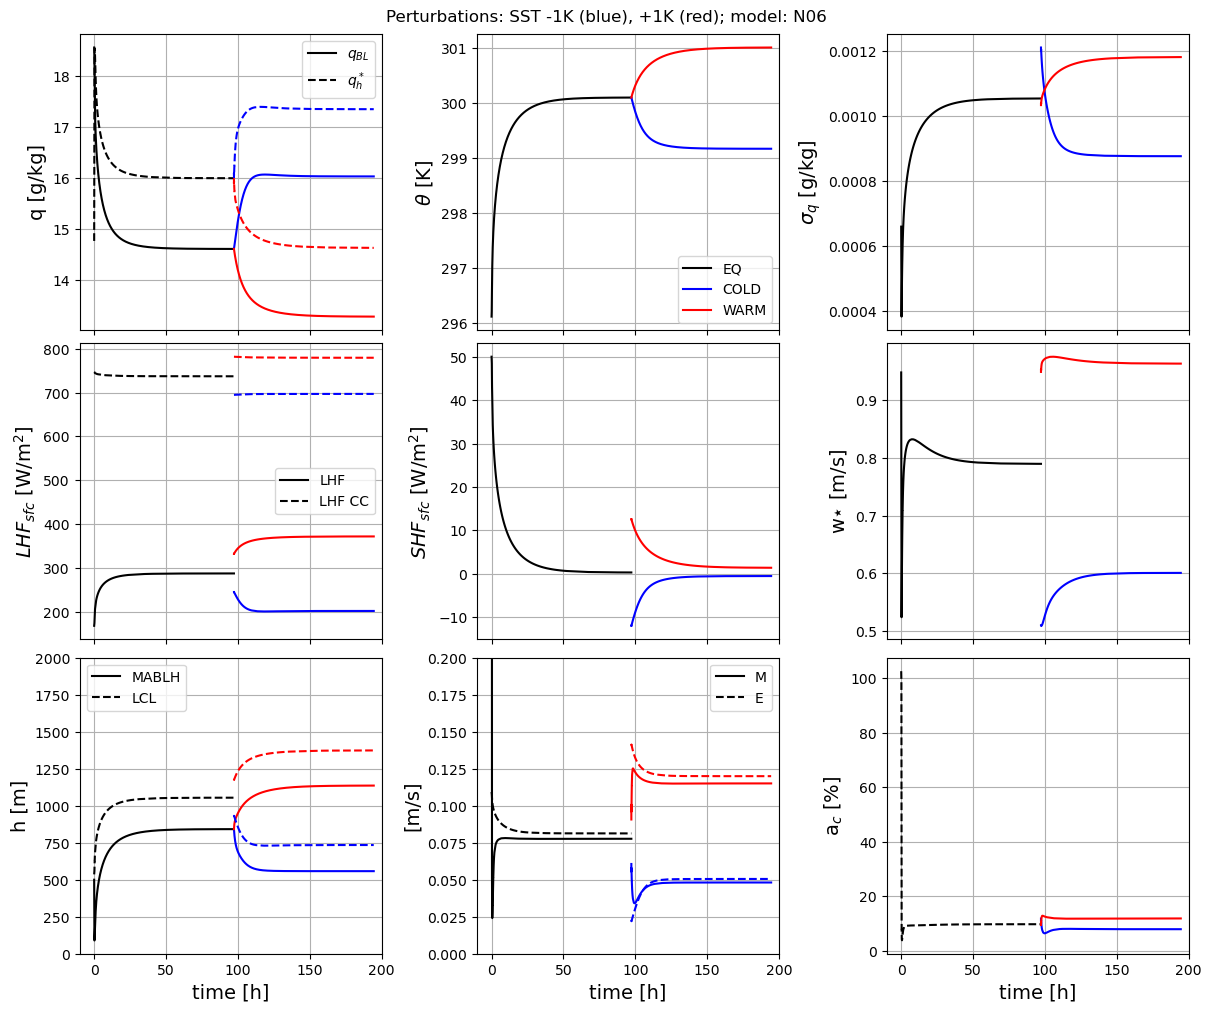

In [71]:
fig, ax = plt.subplots(3,3,figsize=(12,10),sharex=True,constrained_layout=True)
# label_model = 'BOX' if box_model_bool else 'full'
fig.suptitle(f'Perturbations: SST -1K (blue), +1K (red); model: N06')
import matplotlib.lines as mlines




##### temperature  ######
ax[0,1].plot(sol_N06_eq.t/3600,th_eq,'k', label='EQ')
ax[0,1].plot(sol_N06_eqPert_cold.t/3600,th_cold,'blue', label='COLD')
ax[0,1].plot(sol_N06_eqPert_warm.t/3600,th_warm,'r', label='WARM')
ax[0,1].set_ylabel(r'$\theta$ [K]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()
ax[0,1].legend(loc='best')

############## moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label=r'$q_{BL}$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label=r'$q^*_{h}$', linestyle='--')
ax[0,0].plot(sol_N06_eq.t/3600,q_eq*1e3,'k')
ax[0,0].plot(sol_N06_eqPert_cold.t/3600,q_cold*1e3,'blue')
ax[0,0].plot(sol_N06_eqPert_warm.t/3600,q_warm*1e3,'r')
ax[0,0].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['qsat_ext'])*1e3,'--k')
ax[0,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['qsat_ext'])*1e3,'--b')
ax[0,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['qsat_ext'])*1e3,'--r')
ax[0,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,0].set_ylim(0,20)
ax[0,0].grid()
ax[0,0].legend(handles=[solid_line, dashed_line])




######  LHF  #####
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
ax[1,0].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['LHF_ext']),'k', label='LHF_eq')
ax[1,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['LHF_ext']),'b', label='LHF_cold')
ax[1,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['LHF_ext']),'r', label='LHF_warm')
ax[1,0].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['LHF_CC_ext']),'--k', label='LHF CC eq')
ax[1,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['LHF_CC_ext']),'--b', label='LHF CC cold')
ax[1,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['LHF_CC_ext']),'--r', label='LHF CC warm')
ax[1,0].set_ylabel(r'$LHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,0].set_ylim(0,500)
ax[1,0].grid()
ax[1,0].legend(handles=[solid_line, dashed_line])

######  SHF  #####
ax[1,1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['SHF_ext']),'k', label='SHF_eq')
ax[1,1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['SHF_ext']),'b', label='SHF_cold')
ax[1,1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['SHF_ext']),'r', label='SHF_warm')
ax[1,1].set_ylabel(r'$SHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()





#################  h and LCL  ##################
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[2,0].plot(sol_N06_eq.t/3600,h_eq,'k')
ax[2,0].plot(sol_N06_eqPert_cold.t/3600,h_cold,'b')
ax[2,0].plot(sol_N06_eqPert_warm.t/3600,h_warm,'r')
## LCL ##
ax[2,0].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['LCL_ext']),'--k')
ax[2,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['LCL_ext']),'--b')
ax[2,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['LCL_ext']),'--r')
ax[2,0].set_ylabel('h [m]',fontsize=14)
ax[2,0].set_ylim(0,2e3)
ax[2,0].grid()
ax[2,0].legend(handles=[solid_line, dashed_line], loc='upper left')



#########  M and E  ############
# Create custom legend handles for solid and dashed lines
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
ax[2,1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['M_ext']),'k', label='M_eq')
ax[2,1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['M_ext']),'b', label='M_cold')
ax[2,1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['M_ext']),'r', label='M_warm')

ax[2,1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['E_ext']),'--k', label='E_eq')
ax[2,1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['E_ext']),'--b', label='E_cold')
ax[2,1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['E_ext']),'--r', label='E_warm')
ax[2,1].set_ylim(0,0.2)
ax[2,1].grid()
ax[2,1].legend(handles=[solid_line, dashed_line])
ax[2,1].set_ylabel('[m/s]',fontsize=14)




#### what's left ####
ax[0,-1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['sigma_q_ext']),'k', label='eq')
ax[0,-1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['sigma_q_ext']),'b', label='cold')
ax[0,-1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['sigma_q_ext']),'r', label='warm')
ax[0,-1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[0,-1].set_ylim(0,1.5)
ax[0,-1].grid()

ax[1,-1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['w_star_ext']),'k', label='eq')
ax[1,-1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['w_star_ext']),'b', label='cold')
ax[1,-1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['w_star_ext']),'r', label='warm')
ax[1,-1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[1,-1].set_ylim(0.3,1.2)
ax[1,-1].grid()


ax[2,-1].plot(time_ext_N06_eq/3600, np.array(dict_ext_N06_eq['area_c_ext'])*100,'--k', label='ac_eq')
ax[2,-1].plot(time_ext_N06_cold/3600, np.array(dict_ext_N06_eqPert_cold['area_c_ext'])*100,'b', label='ac_cold')
ax[2,-1].plot(time_ext_N06_warm/3600, np.array(dict_ext_N06_eqPert_warm['area_c_ext'])*100,'r', label='ac_warm')
ax[2,-1].set_ylabel('a$_c$ [%]',fontsize=14)
# ax[2,-1].set_ylim(0,20)
ax[2,-1].grid()




ax[2,0].set_xlabel('time [h]',fontsize=14)
ax[2,1].set_xlabel('time [h]',fontsize=14)
ax[2,2].set_xlabel('time [h]',fontsize=14)
ax[2,0].set_xlim(-10,200)
ax[2,1].set_xlim(-10,200)
ax[2,2].set_xlim(-10,200)

filename = '/venus/tesi_ale/img_bulk/SST_PlusMinus1_N06.pdf'
print(filename)
# plt.savefig(filename)
del filename

# Neggers 2006 + Stevens 2002 : add momentum equation

In [3]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [4]:
q_s*1e3

NameError: name 'q_s' is not defined

In [5]:
#######################  set parameters and initial conditions from here on  #####################

U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

E_frac = 1    # modulate strength of entrainment
frac_Ustar = 0.5
 
    
    
# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
# q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 299.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3



# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.5        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 2.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015          # [hPa], surface pressure


y0 = [500, q_s - q_free_0, th_s-3, U_free, V_free]

max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
# t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)

ii=0

dict_ext_NS = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }



###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
# 
sol_NS = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, \
                   args=(SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS, frac_Ustar))#, t_eval=t_eval)


In [34]:
np.nanmean(np.array(dict_ext_NS['area_c_ext']))

0.07195271125338303

equilibrium h = 767.1498316899408 m
equilibrium q = 13.773386310038724 g/kg
equilibrium th = 298.84479112090025 K
equilibrium a$_c$ = 6.711035495492506%
equilibrium w$^*$ = 0.7450496615256199 m/s


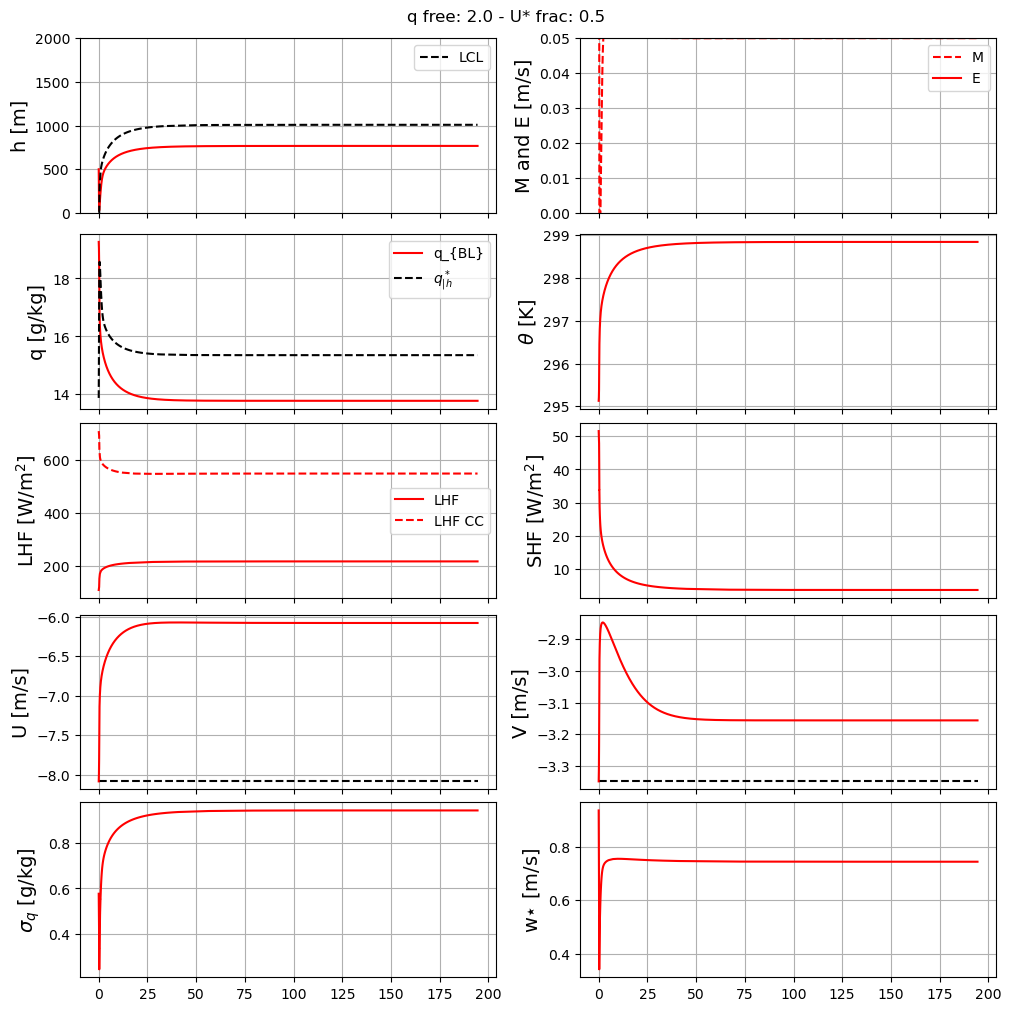

In [37]:
# Plots for a single run.
h = sol_NS.y[0]
q = sol_NS.y[1]
th = sol_NS.y[2]
U = sol_NS.y[3]
V = sol_NS.y[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS = np.max(sol_NS.t)
dt_NS = t_final_NS/3600/len(dict_ext_NS['E_ext']) # [h]
time_ext_NS = np.arange(len(dict_ext_NS['E_ext']))*dt_NS

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(dict_ext_NS['area_c_ext'][-1]*100)+'%')
print('equilibrium w$^*$ = '+str(dict_ext_NS['w_star_ext'][-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)
fig.suptitle(f'q free: {q_free_0*1e3} - U* frac: {frac_Ustar}')

# ax[0,0].plot(sol_N06.t/3600,h_CV,'k')
ax[0,0].plot(sol_NS.t/3600,h,'r')
ax[0,0].plot(time_ext_NS, np.array(dict_ext_NS['LCL_ext']),'--k', label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend()


##########  M and E  ############

ax[0,1].plot(time_ext_NS,np.array(dict_ext_NS['M_ext']),'--r', label='M')
ax[0,1].plot(time_ext_NS,np.array(dict_ext_NS['E_ext']),'r',   label='E')
ax[0,1].set_ylabel('M and E [m/s]',fontsize=14)
ax[0,1].set_ylim(0,0.05)
ax[0,1].grid()
ax[0,1].legend()


# # ax[0,1].plot(time_ext_N06,np.array(area_c_ext_CV)*100,'k')
# ax[0,1].plot(time_ext_NS,np.array(dict_ext_NS['area_c_ext'])*100,'r')
# ax[0,1].set_ylabel(r'a$_c$ [%]',fontsize=14)
# ax[0,1].set_ylim(-5,20)
# ax[0,1].grid()

# plt.plot(sol_NS.t/3600,sol_NS.y[2],'.')
# plt.ylabel('th [K]',fontsize=14)
# plt.xlabel('time [h]',fontsize=14)
# plt.grid()
# plt.show()


######################################################################

# ax[0,1].plot(sol_N06.t/3600,q_CV*1e3,'k')
ax[1,0].plot(sol_NS.t/3600, q*1e3,'r', label='q_{BL}')
ax[1,0].plot(time_ext_NS, np.array(dict_ext_NS['qsat_ext'])*1e3, '--k', label=r'$q^*_{|h}$')
ax[1,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[1,0].set_ylim(0,20)
ax[1,0].grid()
ax[1,0].legend()

# ax[2,0].plot(time_ext_N06,np.array(LHF_ext_CV),'k')
ax[2,0].plot(time_ext_NS,np.array(dict_ext_NS['LHF_ext']),'r', label='LHF')
ax[2,0].plot(time_ext_NS,np.array(dict_ext_NS['LHF_CC_ext']),'--r', label='LHF CC')
ax[2,0].set_ylabel('LHF [W/m$^2$]',fontsize=14)
# ax[2,0].set_ylim(0,500)
ax[2,0].grid()
ax[2,0].legend()

#######################################################################

ax[1,1].plot(sol_NS.t/3600, th,'r')
ax[1,1].set_ylabel(r'$\theta$ [K]',fontsize=14)
# ax[1,1].set_ylim(0,20)
ax[1,1].grid()

# ax[2,0].plot(time_ext_N06,np.array(LHF_ext_CV),'k')
ax[2,1].plot(time_ext_NS,np.array(dict_ext_NS['SHF_ext']),'r')
ax[2,1].set_ylabel('SHF [W/m$^2$]',fontsize=14)
# ax[2,1].set_ylim(0,500)
ax[2,1].grid()




########   wind   ########
ax[3,0].hlines(U_free,np.min(sol_NS.t/3600),np.max(sol_NS.t/3600),'k',linestyle='dashed')
ax[3,0].plot(sol_NS.t/3600,U,'r')
ax[3,0].set_ylabel('U [m/s]',fontsize=14)
#ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].hlines(V_free,np.min(sol_NS.t/3600),np.max(sol_NS.t/3600),'k',linestyle='dashed')
ax[3,1].plot(sol_NS.t/3600,V,'r')
ax[3,1].set_ylabel('V [m/s]',fontsize=14)
#ax[3,1].set_ylim(0,0.10)
ax[3,1].grid()



##### remaining things  ######

ax[4,0].plot(time_ext_NS,np.array(dict_ext_NS['sigma_q_ext'])*1e3,'r')
ax[4,0].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[4,0].set_ylim(0,1.5)
ax[4,0].grid()

ax[4,1].plot(time_ext_NS,np.array(dict_ext_NS['w_star_ext']),'r')
ax[4,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[4,1].set_ylim(0.4,1.2)
ax[4,1].grid()



# ax[4,0].set_xlabel('time [h]',fontsize=14)
# ax[4,1].set_xlabel('time [h]',fontsize=14)
# ax[4,0].set_xlim(0,140)
# ax[4,1].set_xlim(0,140)

In [6]:
####################   EQUILIBRIUM h   ####################
h_equilibrium = h[-1]

# I do 2 things here:
## - once equilibrium is set, modify SST by 1K
## - I can choose between normal model and box model (dh_dt = 0)

In [6]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [7]:
#############################   CHOICE OF MODEL FIRST THING FIRST  #################################
box_model_bool = False
equations_model = neggers_stevens.neggers_stevens_boxModel if box_model_bool else neggers_stevens.neggers_et_al_2006_stevens_et_al_2002





#######################  set parameters and initial conditions from here on  #####################

U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

E_frac = 1    # modulate strength of entrainment
frac_Ustar = 0.9

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


####  set initial conditions  ####

if box_model_bool:
    y0 = [h_equilibrium, q_s - q_free, th_s-3, U_free, V_free]
else:
    y0 = [500, q_s - q_free, th_s-3, U_free, V_free]

    
# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 2.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = ref_p          # [hPa], surface pressure


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


ii=0

dict_ext_NS_eq = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

## initial unperturbed arguments ##
args_initial = (SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eq, frac_Ustar)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
sol_NS_eq = solve_ivp(equations_model, [0,t_split], y0, t_eval = t_eval_eq,\
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_NS_eq.y[:,-1]



### concatenate solutions
# t_combined_cold, t_combined_warm = np.concatenate((sol_NS_eq.t, sol_NS_eqPert_cold.t)), np.concatenate((sol_NS_eq.t, sol_NS_eqPert_warm.t))
# y_combined_cold, y_combined_warm = np.hstack((sol_NS_eq.y, sol_NS_eqPert_cold.y)), np.hstack((sol_NS_eq.y, sol_NS_eqPert_warm.y))

In [8]:
dict_ext_NS_eqPert_cold = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , cool SST     ##########
args_modif_cold = (SST_0-1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_cold, E_frac)

t_eval_cold = np.arange(t_split, max_t, dt_max)

sol_NS_eqPert_cold = solve_ivp(equations_model, [t_split,max_t], y0_split, t_eval = t_eval_cold,\
                               dense_output=True, max_step=dt_max, args=args_modif_cold)



In [9]:
dict_ext_NS_eqPert_warm = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }

#########   after reaching equilibrium , warm SST     ##########
args_modif_warm = (SST_0+1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert_warm, E_frac)

t_eval_warm = np.arange(t_split, max_t, dt_max)

sol_NS_eqPert_warm = solve_ivp(equations_model, [t_split,max_t], y0_split, t_eval = t_eval_warm,\
                               dense_output=True, max_step=dt_max, args=args_modif_warm)

In [10]:
h_eq, h_cold, h_warm   =  sol_NS_eq.y[0], sol_NS_eqPert_cold.y[0], sol_NS_eqPert_warm.y[0]   ##  y_combined[0]
q_eq, q_cold, q_warm =  sol_NS_eq.y[1], sol_NS_eqPert_cold.y[1], sol_NS_eqPert_warm.y[1]   #y_combined[1]
th_eq, th_cold, th_warm = sol_NS_eq.y[2], sol_NS_eqPert_cold.y[2], sol_NS_eqPert_warm.y[2]   #y_combined[2]
U_eq, U_cold, U_warm =  sol_NS_eq.y[3], sol_NS_eqPert_cold.y[3], sol_NS_eqPert_warm.y[3]   #y_combined[3]
V_eq, V_cold, V_warm =  sol_NS_eq.y[4], sol_NS_eqPert_cold.y[4], sol_NS_eqPert_warm.y[4]   #y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS_eq, t_final_NS_cold, t_final_NS_warm = np.max(sol_NS_eq.t),\
                                                  np.max(sol_NS_eqPert_cold.t),\
                                                  np.max(sol_NS_eqPert_warm.t)

dt_NS_eq, dt_NS_cold, dt_NS_warm = t_final_NS_eq   / len(dict_ext_NS_eq['E_ext']),\
                                   (t_final_NS_cold - t_final_NS_eq) / len(dict_ext_NS_eqPert_cold['E_ext']),\
                                   (t_final_NS_warm - t_final_NS_eq) / len(dict_ext_NS_eqPert_warm['E_ext']) # [h]

time_ext_NS_eq   = np.arange(len(dict_ext_NS_eq['E_ext']))* dt_NS_eq
time_ext_NS_cold = np.arange(len(dict_ext_NS_eqPert_cold['E_ext']), len(dict_ext_NS_eqPert_cold['E_ext']) / factor_time) * dt_NS_cold
time_ext_NS_warm = np.arange(len(dict_ext_NS_eqPert_warm['E_ext']), len(dict_ext_NS_eqPert_warm['E_ext']) / factor_time) * dt_NS_warm

# print('equilibrium h = '+str(h[-1])+' m')
# print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
# print('equilibrium th = ' +str(th[-1])+' K')
# print('equilibrium a$_c$ = '+str(dict_ext_NS_eqPert['area_c_ext'][-1]*100)+'%')
# print('equilibrium w$^*$ = '+str(dict_ext_NS_eqPert['w_star_ext'][-1])+' m/s')

/venus/tesi_ale/img_bulk/SST_PlusMinus1_BoxModel_E1.pdf


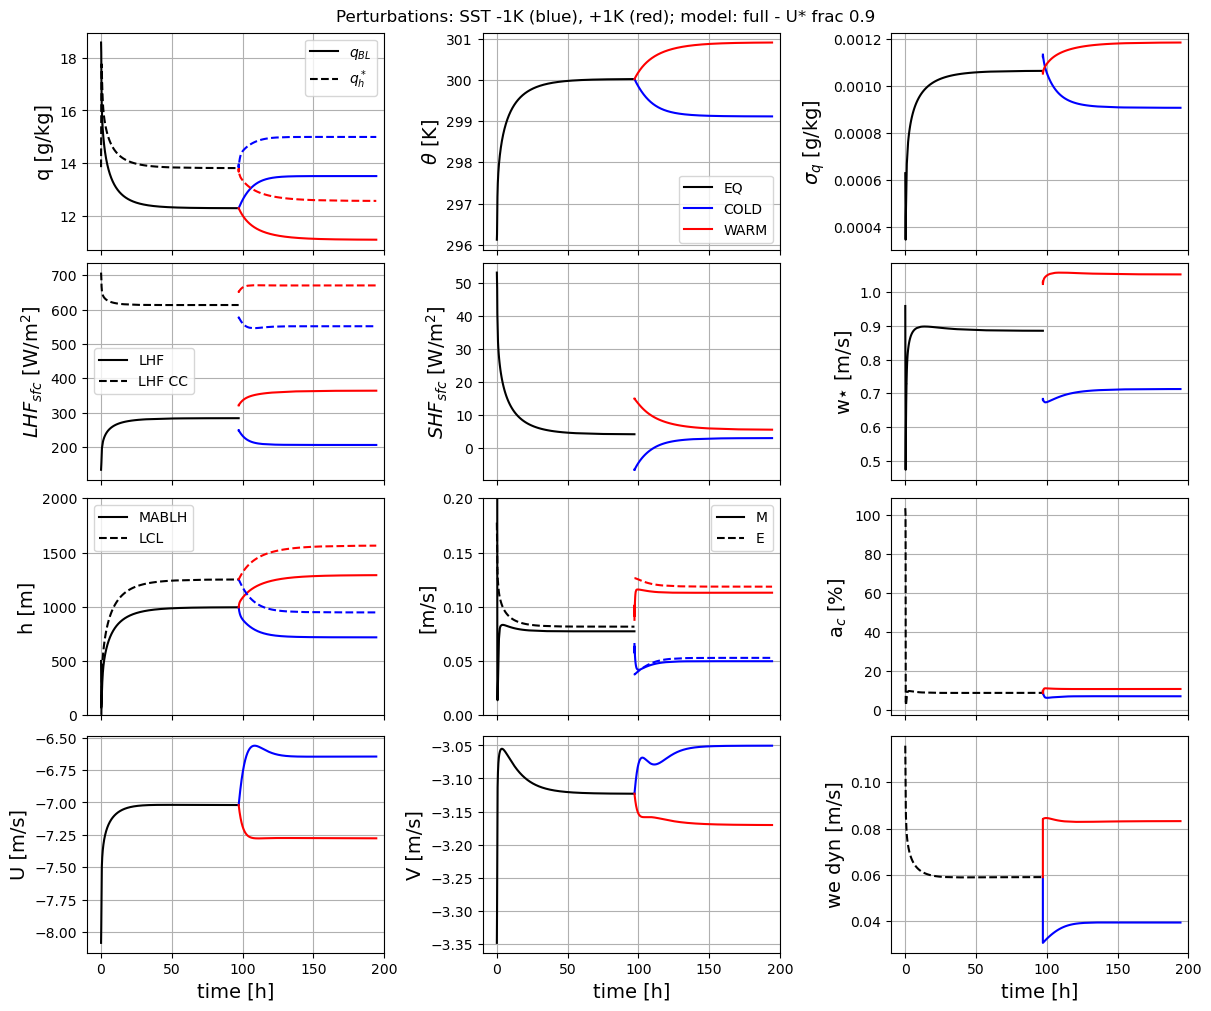

In [11]:
fig, ax = plt.subplots(4,3,figsize=(12,10),sharex=True,constrained_layout=True)
label_model = 'BOX' if box_model_bool else 'full'
fig.suptitle(f'Perturbations: SST -1K (blue), +1K (red); model: {label_model} - U* frac {frac_Ustar}')
import matplotlib.lines as mlines




##### temperature  ######
ax[0,1].plot(sol_NS_eq.t/3600,th_eq,'k', label='EQ')
ax[0,1].plot(sol_NS_eqPert_cold.t/3600,th_cold,'blue', label='COLD')
ax[0,1].plot(sol_NS_eqPert_warm.t/3600,th_warm,'r', label='WARM')
ax[0,1].set_ylabel(r'$\theta$ [K]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()
ax[0,1].legend(loc='best')

############## moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label=r'$q_{BL}$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label=r'$q^*_{h}$', linestyle='--')
ax[0,0].plot(sol_NS_eq.t/3600,q_eq*1e3,'k')
ax[0,0].plot(sol_NS_eqPert_cold.t/3600,q_cold*1e3,'blue')
ax[0,0].plot(sol_NS_eqPert_warm.t/3600,q_warm*1e3,'r')
ax[0,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['qsat_ext'])*1e3,'--k')
ax[0,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['qsat_ext'])*1e3,'--b')
ax[0,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['qsat_ext'])*1e3,'--r')
ax[0,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,0].set_ylim(0,20)
ax[0,0].grid()
ax[0,0].legend(handles=[solid_line, dashed_line])




######  LHF  #####
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
ax[1,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LHF_ext']),'k', label='LHF_eq')
ax[1,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_ext']),'b', label='LHF_cold')
ax[1,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_ext']),'r', label='LHF_warm')
ax[1,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LHF_CC_ext']),'--k', label='LHF CC eq')
ax[1,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_CC_ext']),'--b', label='LHF CC cold')
ax[1,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_CC_ext']),'--r', label='LHF CC warm')
ax[1,0].set_ylabel(r'$LHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,0].set_ylim(0,500)
ax[1,0].grid()
ax[1,0].legend(handles=[solid_line, dashed_line])

######  SHF  #####
ax[1,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['SHF_ext']),'k', label='SHF_eq')
ax[1,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['SHF_ext']),'b', label='SHF_cold')
ax[1,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['SHF_ext']),'r', label='SHF_warm')
ax[1,1].set_ylabel(r'$SHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()





#################  h and LCL  ##################
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[2,0].plot(sol_NS_eq.t/3600,h_eq,'k')
ax[2,0].plot(sol_NS_eqPert_cold.t/3600,h_cold,'b')
ax[2,0].plot(sol_NS_eqPert_warm.t/3600,h_warm,'r')
## LCL ##
ax[2,0].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['LCL_ext']),'--k')
ax[2,0].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['LCL_ext']),'--b')
ax[2,0].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['LCL_ext']),'--r')
ax[2,0].set_ylabel('h [m]',fontsize=14)
ax[2,0].set_ylim(0,2e3)
ax[2,0].grid()
ax[2,0].legend(handles=[solid_line, dashed_line], loc='upper left')



#########  M and E  ############
# Create custom legend handles for solid and dashed lines
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
ax[2,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['M_ext']),'k', label='M_eq')
ax[2,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['M_ext']),'b', label='M_cold')
ax[2,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['M_ext']),'r', label='M_warm')

ax[2,1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['E_ext']),'--k', label='E_eq')
ax[2,1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['E_ext']),'--b', label='E_cold')
ax[2,1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['E_ext']),'--r', label='E_warm')
ax[2,1].set_ylim(0,0.2)
ax[2,1].grid()
ax[2,1].legend(handles=[solid_line, dashed_line])
ax[2,1].set_ylabel('[m/s]',fontsize=14)



#######  wind  ######
# ax[3,0].hlines(U_free,np.min(sol_NS_eq.t/3600),np.max(sol_NS_eq.t/3600),'k',linestyle='dashed')
ax[3,0].plot(sol_NS_eq.t/3600, U_eq, 'k')
ax[3,0].plot(sol_NS_eqPert_cold.t/3600, U_cold,'blue')
ax[3,0].plot(sol_NS_eqPert_warm.t/3600, U_warm,'r')
ax[3,0].set_ylabel('U [m/s]',fontsize=14)
#ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

# ax[3,1].hlines(V_free,np.min(sol_NS_eq.t/3600),np.max(sol_NS_eq.t/3600),'k',linestyle='dashed')
ax[3,1].plot(sol_NS_eq.t/3600, V_eq, 'k')
ax[3,1].plot(sol_NS_eqPert_cold.t/3600, V_cold,'blue')
ax[3,1].plot(sol_NS_eqPert_warm.t/3600, V_warm,'r')
ax[3,1].set_ylabel('V [m/s]',fontsize=14)
#ax[3,1].set_ylim(0,0.10)
ax[3,1].grid()




#### what's left ####
ax[0,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['sigma_q_ext']),'k', label='eq')
ax[0,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['sigma_q_ext']),'b', label='cold')
ax[0,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['sigma_q_ext']),'r', label='warm')
ax[0,-1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[0,-1].set_ylim(0,1.5)
ax[0,-1].grid()

ax[1,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['w_star_ext']),'k', label='eq')
ax[1,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['w_star_ext']),'b', label='cold')
ax[1,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['w_star_ext']),'r', label='warm')
ax[1,-1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[1,-1].set_ylim(0.3,1.2)
ax[1,-1].grid()


ax[2,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['area_c_ext'])*100,'--k', label='ac_eq')
ax[2,-1].plot(time_ext_NS_cold/3600, np.array(dict_ext_NS_eqPert_cold['area_c_ext'])*100,'b', label='ac_cold')
ax[2,-1].plot(time_ext_NS_warm/3600, np.array(dict_ext_NS_eqPert_warm['area_c_ext'])*100,'r', label='ac_warm')
ax[2,-1].set_ylabel('a$_c$ [%]',fontsize=14)
# ax[2,-1].set_ylim(0,20)
ax[2,-1].grid()


ax[3,-1].plot(time_ext_NS_eq/3600, np.array(dict_ext_NS_eq['we_dyn_ext']),'--k', label='we_eq')
ax[3,-1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(np.array(dict_ext_NS_eqPert_cold['we_dyn_ext']), 0, np.array(dict_ext_NS_eq['we_dyn_ext'])[-1]),'b', label='we_cold')
ax[3,-1].plot(np.insert((time_ext_NS_cold/3600), 0, time_ext_NS_eq[-1]/3600), np.insert(np.array(dict_ext_NS_eqPert_warm['we_dyn_ext']), 0, np.array(dict_ext_NS_eq['we_dyn_ext'])[-1]),'r', label='we_warm')
ax[3,-1].set_ylabel('we dyn [m/s]',fontsize=14)
# ax[3,-1].set_ylim(0,20)
ax[3,-1].grid()



ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,2].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(-10,200)
ax[3,1].set_xlim(-10,200)
ax[3,2].set_xlim(-10,200)

filename = '/venus/tesi_ale/img_bulk/SST_PlusMinus1_BoxModel_E1.pdf'
print(filename)
# plt.savefig(filename)
del filename

In [10]:
type(dict_ext_NS_eq['E_ext'])

list

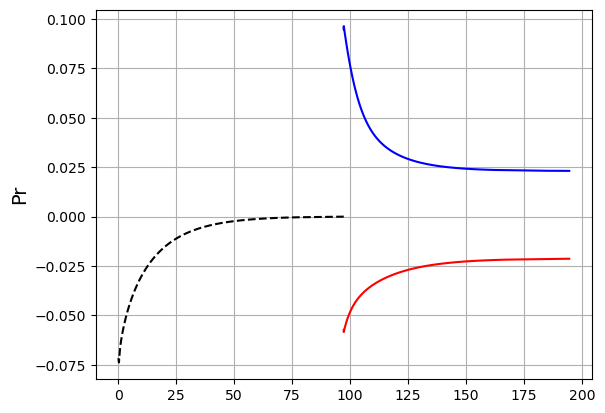

In [15]:
Pr_eq = np.array(dict_ext_NS_eq['we_dyn_ext'])/np.array(dict_ext_NS_eq['E_ext'])
Pr_eq = Pr_eq
plt.plot(time_ext_NS_eq/3600, Pr_eq - Pr_eq[-1],'--k', label='Pr_eq')

we_cold = np.array(dict_ext_NS_eqPert_cold['we_dyn_ext'])
E_cold = np.array(dict_ext_NS_eqPert_cold['E_ext'])

plt.plot((time_ext_NS_cold/3600), we_cold/E_cold - Pr_eq[-1],'b', label='Pr_cold')

we_warm = np.array(dict_ext_NS_eqPert_warm['we_dyn_ext'])
E_warm = np.array(dict_ext_NS_eqPert_warm['E_ext'])

plt.plot(time_ext_NS_warm/3600, we_warm/E_warm - Pr_eq[-1],'r', label='Pr_warm')
plt.ylabel('Pr',fontsize=14)
# plt.set_ylim(0,20)
plt.grid()

## Parentesi: dinamico - statico (NS - N06)

In [61]:
h_eq_NS, h_cold_NS, h_warm_NS   =  sol_NS_eq.y[0], sol_NS_eqPert_cold.y[0], sol_NS_eqPert_warm.y[0]   ##  y_combined[0]
q_eq_NS, q_cold_NS, q_warm_NS =  sol_NS_eq.y[1], sol_NS_eqPert_cold.y[1], sol_NS_eqPert_warm.y[1]   #y_combined[1]
th_eq_NS, th_cold_NS, th_warm_NS = sol_NS_eq.y[2], sol_NS_eqPert_cold.y[2], sol_NS_eqPert_warm.y[2]   #y_combined[2]

(-10.0, 200.0)

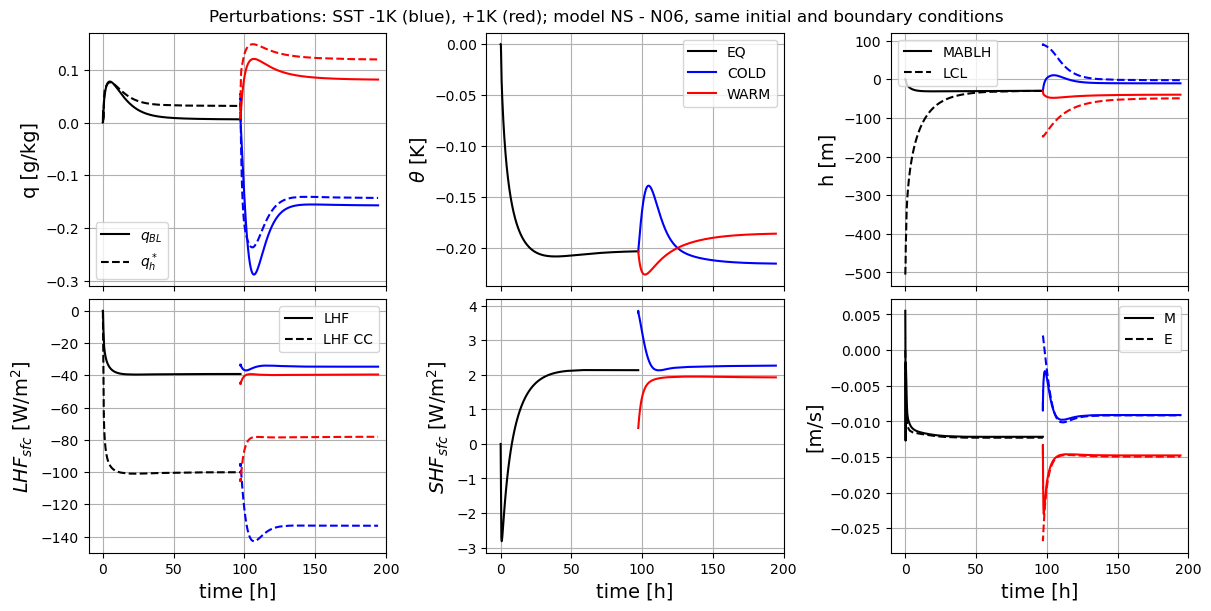

In [70]:
fig, ax = plt.subplots(2,3,figsize=(12,6),sharex=True,constrained_layout=True)
# label_model = 'BOX' if box_model_bool else 'full'
fig.suptitle(f'Perturbations: SST -1K (blue), +1K (red); model NS - N06, same initial and boundary conditions')
import matplotlib.lines as mlines




##### temperature  ######
ax[0,1].plot(sol_N06_eq.t/3600, - th_eq + th_eq_NS,'k', label='EQ')
ax[0,1].plot(sol_N06_eqPert_cold.t/3600,th_cold_NS - th_cold,'blue', label='COLD')
ax[0,1].plot(sol_N06_eqPert_warm.t/3600,th_warm_NS - th_warm,'r', label='WARM')
ax[0,1].set_ylabel(r'$\theta$ [K]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()
ax[0,1].legend(loc='best')

############## moisture  ##########
solid_line = mlines.Line2D([], [], color='k', label=r'$q_{BL}$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label=r'$q^*_{h}$', linestyle='--')
ax[0,0].plot(sol_N06_eq.t/3600,(q_eq_NS - q_eq)*1e3,'k')
ax[0,0].plot(sol_N06_eqPert_cold.t/3600,(q_cold_NS - q_cold)*1e3,'blue')
ax[0,0].plot(sol_N06_eqPert_warm.t/3600,(q_warm_NS - q_warm)*1e3,'r')
ax[0,0].plot(time_ext_N06_eq/3600,   (np.array(dict_ext_NS_eq['qsat_ext']) - np.array(dict_ext_N06_eq['qsat_ext']))*1e3,'--k')
ax[0,0].plot(time_ext_N06_cold/3600, (np.array(dict_ext_NS_eqPert_cold['qsat_ext']) - np.array(dict_ext_N06_eqPert_cold['qsat_ext']))*1e3,'--b')
ax[0,0].plot(time_ext_N06_warm/3600, (np.array(dict_ext_NS_eqPert_warm['qsat_ext']) - np.array(dict_ext_N06_eqPert_warm['qsat_ext']))*1e3,'--r')
ax[0,0].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,0].set_ylim(0,20)
ax[0,0].grid()
ax[0,0].legend(handles=[solid_line, dashed_line])




######  LHF  #####
solid_line = mlines.Line2D([], [], color='k', label='LHF', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LHF CC', linestyle='--')
ax[1,0].plot(time_ext_N06_eq/3600,   np.array(dict_ext_NS_eq['LHF_ext']) - np.array(dict_ext_N06_eq['LHF_ext']),'k', label='LHF_eq')
ax[1,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_ext']) - np.array(dict_ext_N06_eqPert_cold['LHF_ext']),'b', label='LHF_cold')
ax[1,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_ext']) - np.array(dict_ext_N06_eqPert_warm['LHF_ext']),'r', label='LHF_warm')
ax[1,0].plot(time_ext_N06_eq/3600,   np.array(dict_ext_NS_eq['LHF_CC_ext']) - np.array(dict_ext_N06_eq['LHF_CC_ext']),'--k', label='LHF CC eq')
ax[1,0].plot(time_ext_N06_cold/3600, np.array(dict_ext_NS_eqPert_cold['LHF_CC_ext']) - np.array(dict_ext_N06_eqPert_cold['LHF_CC_ext']),'--b', label='LHF CC cold')
ax[1,0].plot(time_ext_N06_warm/3600, np.array(dict_ext_NS_eqPert_warm['LHF_CC_ext']) - np.array(dict_ext_N06_eqPert_warm['LHF_CC_ext']),'--r', label='LHF CC warm')
ax[1,0].set_ylabel(r'$LHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,0].set_ylim(0,500)
ax[1,0].grid()
ax[1,0].legend(handles=[solid_line, dashed_line])

######  SHF  #####
ax[1,1].plot(time_ext_N06_eq/3600, np.array(dict_ext_NS_eq['SHF_ext']) - np.array(dict_ext_N06_eq['SHF_ext']),'k', label='SHF_eq')
ax[1,1].plot(time_ext_N06_cold/3600, np.array(dict_ext_NS_eqPert_cold['SHF_ext']) - np.array(dict_ext_N06_eqPert_cold['SHF_ext']),'b', label='SHF_cold')
ax[1,1].plot(time_ext_N06_warm/3600, np.array(dict_ext_NS_eqPert_warm['SHF_ext']) - np.array(dict_ext_N06_eqPert_warm['SHF_ext']),'r', label='SHF_warm')
ax[1,1].set_ylabel(r'$SHF_{sfc}$ [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()





#################  h and LCL  ##################
solid_line = mlines.Line2D([], [], color='k', label='MABLH', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='LCL', linestyle='--')
ax[0,2].plot(sol_N06_eq.t/3600,h_eq_NS - h_eq,'k')
ax[0,2].plot(sol_N06_eqPert_cold.t/3600,h_cold_NS - h_cold,'b')
ax[0,2].plot(sol_N06_eqPert_warm.t/3600,h_warm_NS - h_warm,'r')
## LCL ##
ax[0,2].plot(time_ext_N06_eq/3600,   np.array(dict_ext_NS_eq['LCL_ext']) - np.array(dict_ext_N06_eq['LCL_ext']),'--k')
ax[0,2].plot(time_ext_N06_cold/3600, np.array(dict_ext_NS_eqPert_cold['LCL_ext']) - np.array(dict_ext_N06_eqPert_cold['LCL_ext']),'--b')
ax[0,2].plot(time_ext_N06_warm/3600, np.array(dict_ext_NS_eqPert_warm['LCL_ext']) - np.array(dict_ext_N06_eqPert_warm['LCL_ext']),'--r')
ax[0,2].set_ylabel('h [m]',fontsize=14)
# ax[0,2].set_ylim(0,2e3)
ax[0,2].grid()
ax[0,2].legend(handles=[solid_line, dashed_line], loc='upper left')



#########  M and E  ############
# Create custom legend handles for solid and dashed lines
solid_line = mlines.Line2D([], [], color='k', label='M', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', label='E', linestyle='--')
ax[1,2].plot(time_ext_N06_eq/3600, np.array(dict_ext_NS_eq['M_ext']) - np.array(dict_ext_N06_eq['M_ext']),'k', label='M_eq')
ax[1,2].plot(time_ext_N06_cold/3600, np.array(dict_ext_NS_eqPert_cold['M_ext']) - np.array(dict_ext_N06_eqPert_cold['M_ext']),'b', label='M_cold')
ax[1,2].plot(time_ext_N06_warm/3600, np.array(dict_ext_NS_eqPert_warm['M_ext']) - np.array(dict_ext_N06_eqPert_warm['M_ext']),'r', label='M_warm')

ax[1,2].plot(time_ext_N06_eq/3600, np.array(dict_ext_NS_eq['E_ext']) - np.array(dict_ext_N06_eq['E_ext']),'--k', label='E_eq')
ax[1,2].plot(time_ext_N06_cold/3600,np.array(dict_ext_NS_eqPert_cold['E_ext']) - np.array(dict_ext_N06_eqPert_cold['E_ext']),'--b', label='E_cold')
ax[1,2].plot(time_ext_N06_warm/3600,np.array(dict_ext_NS_eqPert_warm['E_ext']) - np.array(dict_ext_N06_eqPert_warm['E_ext']),'--r', label='E_warm')
# ax[1,2].set_ylim(0,0.2)
ax[1,2].grid()
ax[1,2].legend(handles=[solid_line, dashed_line])
ax[1,2].set_ylabel('[m/s]',fontsize=14)


ax[1,0].set_xlabel('time [h]',fontsize=14)
ax[1,1].set_xlabel('time [h]',fontsize=14)
ax[1,2].set_xlabel('time [h]',fontsize=14)
ax[1,0].set_xlim(-10,200)
ax[1,1].set_xlim(-10,200)
ax[1,2].set_xlim(-10,200)

## FINE PARENTESI

### estimate adjustment timescales analytically 

In [64]:
def set_variables_for_fit(var, var_ext):
    if var_ext in dict_ext_NS_eq.keys():
        var_values_warm = np.array(dict_ext_NS_eqPert_warm[var_ext][2:])
        var_values_cold = np.array(dict_ext_NS_eqPert_cold[var_ext][2:])

        time_warm, time_cold = time_ext_NS_warm[2:]/3600, time_ext_NS_cold[2:]/3600
    else:
        time_warm = sol_NS_eqPert_cold.t/3600; time_cold = sol_NS_eqPert_cold.t/3600
        if var == 'h':
            var_values_warm = h_warm; var_values_cold = h_cold
        if var == 'th':
            var_values_warm = th_warm; var_values_cold = th_cold
        if var == 'q':
            var_values_warm = q_warm; var_values_cold = q_cold
        if var == 'U':
            var_values_warm = U_warm; var_values_cold = U_cold
        if var == 'V':
            var_values_warm = V_warm; var_values_cold = V_cold
            
    return time_warm, time_cold, var_values_warm, var_values_cold

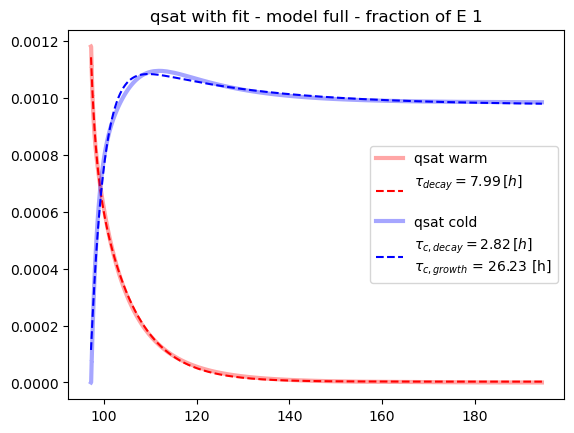

In [133]:

###  THIS NOT FOR MOISTURE

var = 'qsat' ; var_ext = var + '_ext'
time_warm, time_cold, var_values_warm, var_values_cold = set_variables_for_fit(var, var_ext)

from scipy.optimize import curve_fit

def increasing_exp(x, a, b, c):  # "warm"
    return a*(1-np.exp(b*(x-c))) #(a+b*np.exp(c*(x-d)))

def double_exp(x, a, b, c, d, f, g, h):  
    return a+b*np.exp(c*(x-d)) + f*np.exp(g*(x-h))

def increasing_double_exp(x, a, b, c, d, f, g):  
    return a*(1-np.exp(b*(x-c))) + d*np.exp(f*(x-g))

def decreasing_double_exp(x, a, b, c, d, f, g):  
    return a*(1-np.exp(b*(x-c))) + d*np.exp(f*(x-g))

def decreasing_exp(x, a, b, c):  # "cold"
    return a*np.exp(b*(x-c))



x, y = time_warm, var_values_warm
y = y - np.min(y)
# initial_guess = [y[-1], -1/50, 130, -y[-1]+y[0], -1/5, x[0]]   #[y[-1], -1/50, 100, y[-1]-y[0], -1/20, 120]

# # Fit the data to the exponential model
# fit_params_warm, params_covar_warm = curve_fit(decreasing_double_exp, x, y, p0=initial_guess, maxfev=6000)  # bounds=([0, 0, 0, -50], [100, 1000, 10,0])
# a, b, c, d, f, g = fit_params_warm[0], fit_params_warm[1], fit_params_warm[2], fit_params_warm[3], fit_params_warm[4], fit_params_warm[5]
# plt.plot(x, y, 'r', label=f'{var} warm', alpha=0.35, linewidth=3)
# plt.plot(x, decreasing_double_exp(x, a, b, c, d, f, g), '--r', label=r'$\tau_{growth} ='+f' {np.abs(round(1/b,2))} \, [h]$ \n'+r'$\tau_{decay}$ = '+f'{np.abs(round(1/f,2))} [h]' )
# # plt.plot(x, decreasing_double_exp(x, initial_guess[0], initial_guess[1], initial_guess[2], initial_guess[3], initial_guess[4], initial_guess[5]), '--b')

initial_guess = [y[-1], y[-1], -1/50, 130, -y[-1]+y[0], -1/5, x[0]]   #[y[-1], -1/50, 100, y[-1]-y[0], -1/20, 120]

# Fit the data to the exponential model
fit_params_warm, params_covar_warm = curve_fit(double_exp, x, y, p0=initial_guess, maxfev=6000)  # bounds=([0, 0, 0, -50], [100, 1000, 10,0])
a, b, c, d, f, g, h = fit_params_warm[0], fit_params_warm[1], fit_params_warm[2], fit_params_warm[3], fit_params_warm[4], fit_params_warm[5], fit_params_warm[6]
plt.plot(x, y, 'r', label=f'{var} warm', alpha=0.35, linewidth=3)
plt.plot(x, double_exp(x, a, b, c, d, f, g, h), '--r', label=r'$\tau_{decay} ='+f' {np.abs(round(1/c,2))} \, [h]$') #+r'\n $\tau_{decay}$ = '+f'{np.abs(round(1/g,2))} [h]' )
# plt.plot(x, double_exp(x, initial_guess[0], initial_guess[1], initial_guess[2], initial_guess[3], initial_guess[4], initial_guess[5], nitial_guess[6]), '--b')



 

x, y = time_cold, var_values_cold
y = y - np.min(y)
initial_guess = [y[-1], -np.max(y), -1/5, x[0], (np.max(y)-y[-1]), -1/10, 115]  #[y[-1], -1/2, 100, np.max(y)-y[-1], -1/15, 110]

# Fit the data to the exponential model
fit_params_cold, params_covar_cold = curve_fit(double_exp, x, y, p0=initial_guess, maxfev=6000)
a, b, c, d, f, g, h = fit_params_cold[0], fit_params_cold[1], fit_params_cold[2], fit_params_cold[3], fit_params_cold[4], fit_params_cold[5], fit_params_cold[6]
plt.plot(x, y, 'b', label=f'{var} cold', alpha=0.35, linewidth=3)
plt.plot(x, double_exp(x, a, b, c, d, f, g, h), '--b', label=r'$\tau_{c, decay} ='+f' {np.abs(round(1/c,2))} \, [h]$ \n'+ r'$\tau_{c, growth}$ ='+f' {np.abs(round(1/g,2))} [h]')
# plt.plot(x, double_exp(x, initial_guess[0], initial_guess[1], initial_guess[2], initial_guess[3], initial_guess[4], initial_guess[5], initial_guess[6]), '--b')
         
# plt.text(205, 0.0002, '')       
         
plt.title(f'{var} with fit - model {label_model} - fraction of E {E_frac}')
plt.legend(loc='center right')

In [134]:
fit_params_cold

array([ 9.74298773e-04, -1.04311869e-03, -3.54544302e-01,  9.72615670e+01,
        1.02625406e-04, -3.81202899e-02,  1.14150936e+02])

In [121]:
### save files

import pickle


dict_out = {
    'model': label_model,
    'E_frac': E_frac,
    'warm':{
        'x':{'units': 'hr', 'values': time_warm},
        'var':{'units': 'K', 'values': var_values_warm},
        'fit_function': 'decreasing_double_exp', 
        'fit_params': fit_params_warm, 
        'params_covar': params_covar_warm
    },
    
    'cold':{
        'x':{'units': 'hr', 'values': time_cold},
        'var':{'units': 'K', 'values': var_values_cold},
        'fit_function': 'double_exp', 
        'fit_params': fit_params_cold, 
        'params_covar': params_covar_cold
        
    }
}
    
filename_out = var+'_ColdWarm_'+'Model'+label_model+'.pickle'
path = '/venus/tesi_ale/data_bulk/adjustment_timescales/box_model/'+filename_out
print(path)


# import os
# if os.path.exists(path):
#     os.remove(path)
#     print('file removed')

# with open(path, 'wb') as handle:
#     pickle.dump(dict_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     print('file saved')

# del filename_out, path, dict_out

/venus/tesi_ale/data_bulk/adjustment_timescales/box_model/U_ColdWarm_Modelfull.pickle
file saved


/home/alessandro/miniconda3/envs/spec_tesi_clone/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


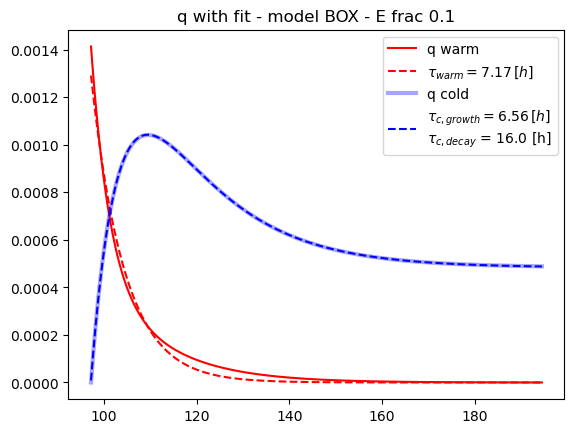

In [182]:

###  THIS IS ALL DEDICATED TO MOISTURE

var = 'q' ; var_ext = var + '_ext'
time_warm, time_cold, var_values_warm, var_values_cold = set_variables_for_fit(var, var_ext)

def compute_derivative(x, field):
    derivative = np.zeros_like(field)
    derivative[0]    = (field[1]-field[0])/(x[1]-x[0])
    derivative[1:-1] = (field[2:]-field[0:-2])/((x[2:]-x[0:-2]))
    derivative[-1]   = (field[-1]-field[-2])/(x[-1]-x[-2])
    return derivative

from scipy.optimize import curve_fit

def increasing_exp(x, a, b, c):  # "warm"
    return a*(1-np.exp(b*(x-c))) #(a+b*np.exp(c*(x-d)))

def increasing_double_exp(x, a, b, c, d, f, g):  
    return a*(1-np.exp(b*(x-c))) + d*np.exp(f*(x-g))

def decreasing_exp(x, a, b, c):  # "cold"
    return a*np.exp(b*(x-c))


x, y = time_warm, var_values_warm
y = y - np.min(y)
initial_guess = [y[-1], -1/20, 100]

# Fit the data to the exponential model
fit_params_warm, params_covar_warm = curve_fit(decreasing_exp, x, y, p0=initial_guess)  # bounds=([0, 0, 0, -50], [100, 1000, 10,0])

a, b, c = fit_params_warm[0], fit_params_warm[1], fit_params_warm[2] #, fit_params[3]
plt.plot(x, y, 'r', label=f'{var} warm')
plt.plot(x, decreasing_exp(x, a, b, c), '--r', label=r'$\tau_{warm} ='+f' {np.abs(round(1/b,2))} \, [h]$')






x, y = time_cold, var_values_cold
y = y - np.min(y)
initial_guess = [y[-1], -1/50, 100, y[-1]-y[0], -1/20, 120]

# Fit the data to the exponential model
fit_params_cold, params_covar_cold = curve_fit(increasing_double_exp, x, y, p0=initial_guess)
a, b, c, d, f, g = fit_params_cold[0], fit_params_cold[1], fit_params_cold[2] , fit_params_cold[3], fit_params_cold[4], fit_params_cold[5]
plt.plot(x, y, 'b', label=f'{var} cold', alpha=0.35, linewidth=3)
plt.plot(x, increasing_double_exp(x, a, b, c, d, f, g), '--b', label=r'$\tau_{c, growth} ='+f' {np.abs(round(1/b,2))} \, [h]$ \n'+ r'$\tau_{c, decay}$ ='+f' {np.abs(round(1/f,2))} [h]')


## on the cold side


plt.title(f'{var} with fit - model {label_model} - E frac {E_frac}')
plt.legend()

In [181]:
### save files

import pickle


dict_out = {
    'model': label_model,
    'E_frac': E_frac,
    'warm':{
        'x':{'units': 'hr', 'values': time_warm},
        'var':{'units': 'K', 'values': var_values_warm},
        'fit_function': 'decreasing_double_exp', 
        'fit_params': fit_params_warm, 
        'params_covar': params_covar_warm
    },
    
    'cold':{
        'x':{'units': 'hr', 'values': time_cold},
        'var':{'units': 'K', 'values': var_values_cold},
        'fit_function': 'decreasing_double_exp', 
        'fit_params': fit_params_cold, 
        'params_covar': params_covar_cold
        
    }
}
    
filename_out = var+'_ColdWarm_'+'Model'+label_model+'.pickle'
path = '/venus/tesi_ale/data_bulk/adjustment_timescales/box_model/'+filename_out
print(path)


# import os
# if os.path.exists(path):
#     os.remove(path)
#     print('file removed')

# with open(path, 'wb') as handle:
#     pickle.dump(dict_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     print('file saved')

# del filename_out, path, dict_out

/venus/tesi_ale/data_bulk/adjustment_timescales/box_model/q_ColdWarm_ModelBOX.pickle
file saved


In [64]:
params_covar_warm

array([[-1.07557050e+04,  8.91111849e-04,  8.31648953e+07],
       [ 8.91111849e-04,  1.16802016e-07, -6.89022563e+00],
       [ 8.31648953e+07, -6.89022563e+00, -6.43044767e+11]])

## run sensitivity tests, with entrainment scaling as well

In [5]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)

8.083945909473758
3.348480033194536


In [12]:
#############################   CHOICE OF MODEL FIRST THING FIRST  #################################
box_model_bool = False;  label_model='Box' if box_model_bool else 'Full'
equations_model = neggers_stevens.neggers_stevens_boxModel if box_model_bool else neggers_stevens.neggers_et_al_2006_stevens_et_al_2002



# Now test the dependence of the solution to some external parameters.

#######################  set parameters and initial conditions from here on  #####################

U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

E_frac = 1    # modulate strength of entrainment
frac_Ustar = 0.9


# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST = 300.4        # [K], sea surface temperature
D = 4.3e-6         # [1/s], large scale divergence
q_free = 10.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free = 308      # [K], free tropospheric liquid virtual potential temperature

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
cpd  = 1004.67                                   # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                                       # J/K/kg, dry air gas constant
ref_p = 1000                                     # [hPa], reference pressure for the potential temperature: is this the surface pressure????
ps = ref_p                                        # [hPa], surface pressure
th_s = SST*(ref_p/ps)**(Rd/cpd)                  # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


####  set initial conditions  ####
# if box_model_bool:
#     y0 = [h_equilibrium, q_s - q_free, th_s-3, U_free, V_free]
# else:
#     y0 = [500, q_s - q_free, th_s-3, U_free, V_free]
    


max_t = 7e5
dt_max = 60
time = [0, max_t]
factor_time = 0.5;  t_split = factor_time*max_t
# t_eval_eq = np.arange(0,t_split,dt_max)
# t_eval_cold_warm = np.arange(t_split,max_t,dt_max)


dict_params = {
        'SST forced': {'values':np.load('/venus/tesi_ale/data_bulk/sensitivities/pdist_sst_forced.npy'), 'units':'K'},
        'SST': {'values': np.arange(299,301.1,0.1), 'units': 'K'},
        'U_free': {'values': np.arange(U_free-5,U_free+5, 1), 'units': 'm/s'},
        'V_free': {'values': np.arange(V_free-5,V_free+5, 0.5), 'units': 'm/s'}, 
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s'},
        'q_free': {'values': np.arange(1e-3,14.0e-3,1e-3), 'units': 'kg/kg'}, 
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K'},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa'},
        'E_frac': {'values': np.linspace(0.01, 2, 20), 'units': 'dimensionless'}
}

param_of_interest = 'SST forced'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
U_eq, V_eq = h_eq.copy(), h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
we_dyn_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()
sigma_q_eq = h_eq.copy()

for jj, SST in enumerate(list_of_values):
    ii=0
    
    
    dict_ext = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[],\
                'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[], 'b_flux_s_NoG_ext':[]}

    th_s = SST*(ref_p/ps)**(Rd/cpd)               
    q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3
    y0 = [500, q_s - q_free, th_s-3, U_free, V_free]
    
    
    sol = solve_ivp(equations_model, time, y0, dense_output=True, max_step=dt_max, args=(SST, D, q_free, th_free, ps, f, U_free,V_free, we, dict_ext, E_frac, frac_Ustar))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    LCL_eq[jj] = dict_ext['LCL_ext'][-1]       if len(dict_ext['LCL_ext']) is not 0 else 999
    
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    U_eq[jj] = sol.y[3][-1]
    V_eq[jj] = sol.y[4][-1]
    
    a_c_eq[jj] = dict_ext['area_c_ext'][-1]    if len(dict_ext['area_c_ext']) is not 0 else 999
    w_star_eq[jj] = dict_ext['w_star_ext'][-1] if len(dict_ext['w_star_ext']) is not 0 else 999
    we_dyn_eq[jj] = dict_ext['we_dyn_ext'][-1] if len(dict_ext['we_dyn_ext']) is not 0 else 999
    M_eq[jj] = dict_ext['M_ext'][-1]           if len(dict_ext['M_ext']) is not 0 else 999
    E_eq[jj] = dict_ext['E_ext'][-1]           if len(dict_ext['E_ext']) is not 0 else 999
    
    LHF_eq[jj] = dict_ext['LHF_ext'][-1]       if len(dict_ext['LHF_ext']) is not 0 else 999
    LHF_CC_eq[jj] = dict_ext['LHF_CC_ext'][-1] if len(dict_ext['LHF_CC_ext']) is not 0 else 999
    SHF_eq[jj] = dict_ext['SHF_ext'][-1]       if len(dict_ext['SHF_ext']) is not 0 else 999
    
    qs_eq[jj] = dict_ext['qs_ext'][-1]         if len(dict_ext['qs_ext']) is not 0 else 999
    qsat_eq[jj] = dict_ext['qsat_ext'][-1]     if len(dict_ext['qsat_ext']) is not 0 else 999
    
    sigma_q_eq[jj] = dict_ext['sigma_q_ext'][-1]  if len(dict_ext['sigma_q_ext']) is not 0 else 999
    
    
    
    if (np.round(100*(jj+1)/len(list_of_values)%10 == 0)):
        print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
        print('---------------------------------------')

print(str(q_free*1e3) + ' g/kg case done')

10.0 percent
---------------------------------------
20.0 percent
---------------------------------------
30.0 percent
---------------------------------------
40.0 percent
---------------------------------------
50.0 percent
---------------------------------------
60.0 percent
---------------------------------------
70.0 percent
---------------------------------------
80.0 percent
---------------------------------------
90.0 percent
---------------------------------------
100.0 percent
---------------------------------------
10.0 g/kg case done


In [7]:
####   run different sensitivity tests 
####   with different q_free values
# collect_eq = {'SST values': list_of_values}

In [13]:
## this is for different values of q_free
dict_eq = { 'M_eq':[], 'E_eq':[], 'LHF_eq':[], 'LHF_CC_eq':[], 'qs_eq':[], 'qsat_eq':[],\
                    'SHF_eq':[], 'LCL_eq':[], 'we_dyn_eq':[], 'h_eq':[], 'q_eq':[], 'th_eq':[], 'U_eq':[], 'V_eq':[] }


dict_eq['h_eq'] = h_eq
dict_eq['LCL_eq'] = LCL_eq

dict_eq['q_eq'] = q_eq
dict_eq['th_eq'] =  th_eq
dict_eq['U_eq'] = U_eq
dict_eq['V_eq'] = V_eq

dict_eq['we_dyn_eq'] =  we_dyn_eq
dict_eq['M_eq'] = M_eq          
dict_eq['E_eq'] = E_eq         

dict_eq['LHF_eq'] = LHF_eq       
dict_eq['LHF_CC_eq'] =  LHF_CC_eq
dict_eq['SHF_eq'] = SHF_eq     

dict_eq['qs_eq'] =  qs_eq       
dict_eq['qsat_eq'] =  qsat_eq   

collect_eq[str(q_free)] = dict_eq

In [14]:
collect_eq.keys()

dict_keys(['SST values', '0.004', '0.007', '0.01'])

In [ ]:
desired_order = ['0.002', '0.004', '0.006', '0.007', '0.01']
collected_eq_reorder = {k: collect_eq[k] for k in desired_order}

In [15]:
import pickle

path = '/venus/tesi_ale/data_bulk/sensitivities/SST_sens_VaryingQFree_REFpSFCp_FORCED.pickle'
with open(path, 'wb') as handle:
    pickle.dump(collect_eq, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('file saved')

file saved


Prandtl Number trend: 0.7824922110885174  to  0.7310782617904584

E frac = 1

/venus/tesi_ale/img_bulk/sensitivities/SST_sens_Full_E1.pdf


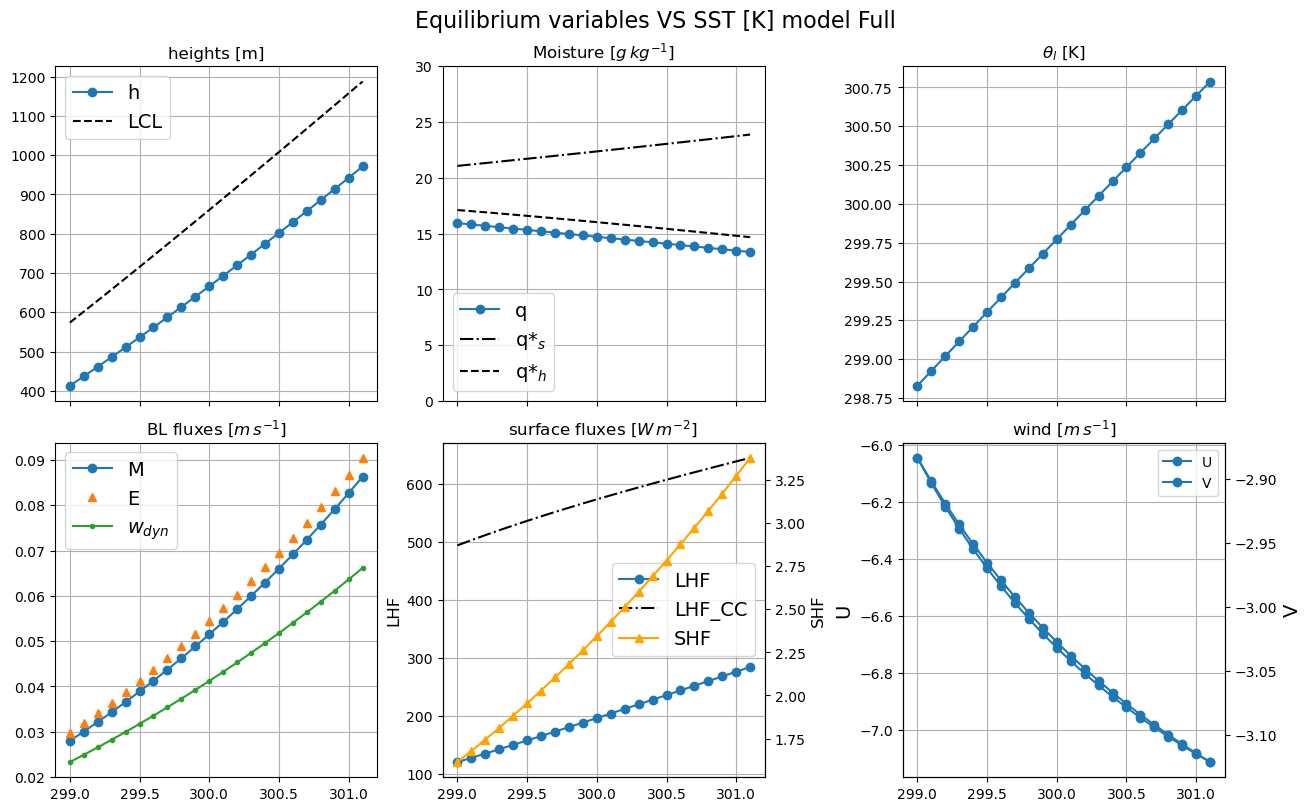

In [24]:
fig, ax = plt.subplots(2,3,figsize=(13,8),sharex=True,constrained_layout=True)
fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']'+f' model {label_model}',fontsize=16) #, E frac {E_frac}


#######  h and LCL  ###########
ax[0,0].set_title('heights [m]')
ax[0,0].plot(list_of_values,h_eq,'-o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].legend(fontsize=14)



#########  moisture  ##########
ax[0,1].set_title(r'Moisture [$g\,kg^{-1}$]')
ax[0,1].plot(list_of_values,q_eq*1e3,'-o',label='q')
ax[0,1].plot(list_of_values,neggers_stevens.qsea(list_of_values-273.15,ps),'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].legend(fontsize=14)
ax[0,1].set_ylim(0,30)


 
#######  temperature  ########
ax[0,2].set_title(r'$\theta_l$ [K]')
ax[0,2].plot(list_of_values,th_eq,'-o')
ax[0,2].grid()


# #####  components of Mass Flux  (M)
# line1 = ax[1,0].plot(list_of_values,a_c_eq*100,'-o')
# ax[1,0].grid()
# ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)

# axino = ax[1,0].twinx()

# line2 = axino.plot(list_of_values, w_star_eq, 'or', label=r'$w^*$')
# axino.set_ylabel('[m/s]',fontsize=14)
# ln = line1+line2
# labs = [l.get_label() for l in ln]
# ax[1, 0].legend(ln, labs, loc='best')




######  entrainment M and E ######
ax[1,0].set_title(r'BL fluxes [$m\,s^{-1}$]')
ax[1,0].plot(list_of_values,M_eq,'-o',label='M')
ax[1,0].plot(list_of_values,E_eq,'^',label='E')
ax[1,0].plot(list_of_values,we_dyn_eq,'.-',label=r'$w_{dyn}$')
ax[1,0].grid()
#ax[1,0].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,0].legend(fontsize=14)
# ax[1,0].set_ylim(0,0.20)



##############  HEAT FLUXES  ################

# Plotting the LHF and LHF_CC on the first axis
ax[1,1].set_title(r'surface fluxes [$W\,m^{-2}$] ')
ax[1,1].plot(list_of_values, LHF_eq, '-o', label='LHF')
ax[1,1].plot(list_of_values, LHF_CC_eq, '-.k', label='LHF_CC')

twinni = ax[1,1].twinx()
twinni.plot(list_of_values, SHF_eq, '-^', color='orange', label='SHF')

ax[1,1].grid()
ax[1,1].set_ylabel('LHF', fontsize=12)
twinni.set_ylabel(r'SHF', fontsize=12)
# twinni.set_ylim([1.5, 2])
lines_labels = ax[1,1].get_lines() + twinni.get_lines()  # Combine lines from both axes
labels = ['LHF', 'LHF_CC', 'SHF']  # Custom labels for the combined legend
ax[1,1].legend(lines_labels, labels, fontsize=14)





##### wind #####
ax[1,2].plot(list_of_values, U_eq, '-o', label='U')
ax[1,2].set_title(r'wind [$m\,s^{-1}$]')
ax[1,2].set_ylabel('U',fontsize=14)
ax[1,2].grid()

axx = ax[1,2].twinx()
axx.plot(list_of_values, V_eq, '-o', label='V')
axx.set_ylabel('V',fontsize=14)
handles1, labels1 = ax[1,2].get_legend_handles_labels()
handles2, labels2 = axx.get_legend_handles_labels()

handles = handles1 + handles2;  labels = labels1 + labels2
ax[1,2].legend(handles, labels, loc='best')


# ##### sigma q #####
# ax[2,2].plot(list_of_values, sigma_q_eq*1e3, '-o', label=r'$\sigma_q$')
# ax[2,2].set_ylabel(r'$\sigma_q$ [g/kg]',fontsize=14)
# #ax[2,2].set_ylim(0,0.10)
# ax[2,2].grid()



# figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')





###########################################à


print(f'Prandtl Number trend: {(we_dyn_eq/E_eq)[0]}  to  {(we_dyn_eq/E_eq)[-1]}')
print()

if param_of_interest is not 'E_frac':
    print('E frac = '+str(E_frac))
    print()


base_path = '/venus/tesi_ale/img_bulk/sensitivities/'+param_of_interest+'_sens_'
filename = base_path + 'BoxModel' if box_model_bool else base_path+'Full'
if param_of_interest is not 'E_frac':
    filename = filename+'_E'+str(E_frac)
filename = filename + '.pdf'
print(filename)
# plt.savefig(filename)



# article image: different q_free for SST sensitivities

/venus/tesi_ale/img_bulk/sensitivities/SST_sens_Full_E1.pdf


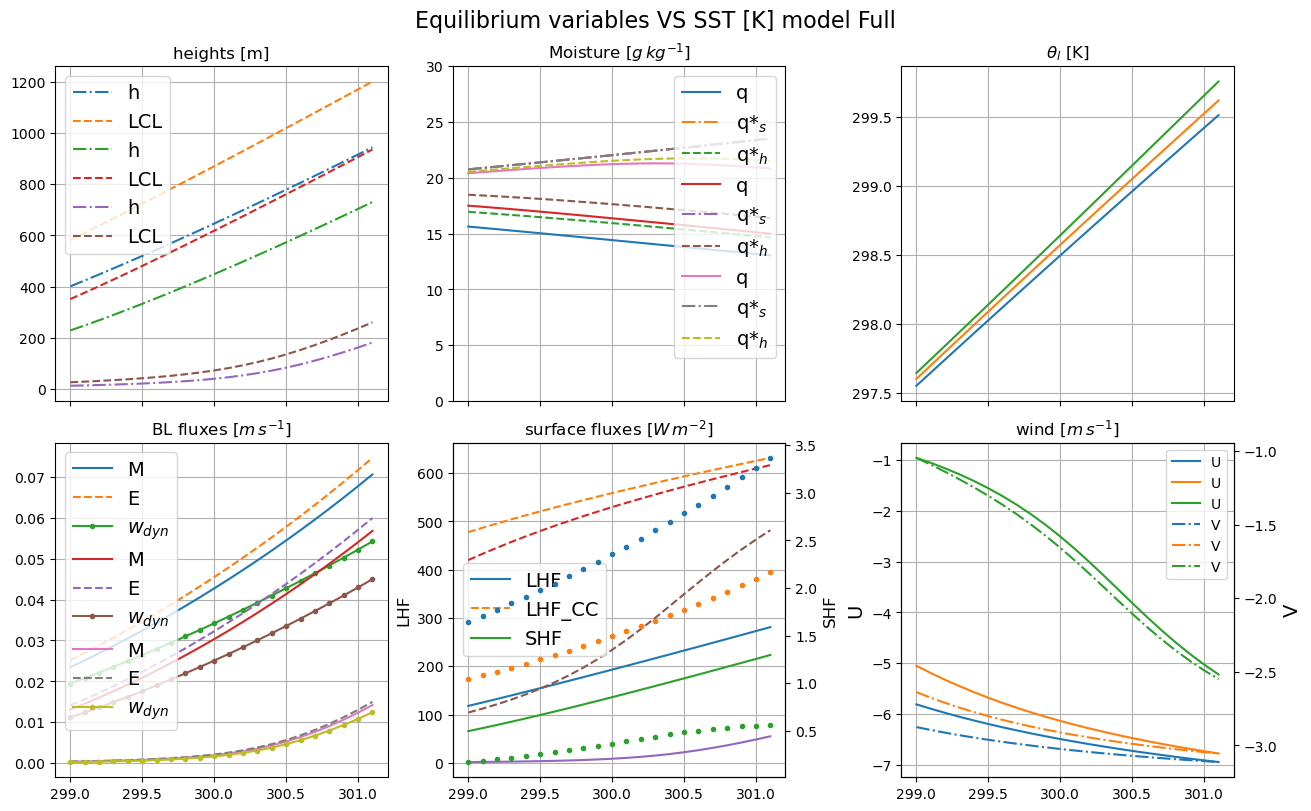

In [63]:
fig, ax = plt.subplots(2,3,figsize=(13,8),sharex=True,constrained_layout=True)
fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']'+f' model {label_model}',fontsize=16) #, E frac {E_frac}


#########  h and LCL  ###########
ax[0,0].set_title('heights [m]')
ax[0,0].grid()

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[0,0].plot(list_of_values, collect_eq_reorder[moist]['h_eq'], '-', label='h')
    ax[0,0].plot(list_of_values, collect_eq_reorder[moist]['LCL_eq'], '--', label='LCL')

ax[0,0].legend(fontsize=14)


#########  moisture  ##########
ax[0,1].set_title(r'Moisture [$g\,kg^{-1}$]')
ax[0,1].grid()
ax[0,1].set_ylim(0,30)

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[0,1].plot(list_of_values, collect_eq_reorder[moist]['q_eq'] * 1e3, '-', label='q')
    ax[0,1].plot(list_of_values, collect_eq_reorder[moist]['qs_eq'] * 1e3, '-.', label='q*$_s$')
    ax[0,1].plot(list_of_values, collect_eq_reorder[moist]['qsat_eq'] * 1e3, '--', label='q*$_h$')

ax[0,1].legend(fontsize=14)


#######  temperature  ########
ax[0,2].set_title(r'$\theta_l$ [K]')
ax[0,2].grid()

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[0,2].plot(list_of_values, collect_eq_reorder[moist]['th_eq'], '-')


######  entrainment M and E ######
ax[1,0].set_title(r'BL fluxes [$m\,s^{-1}$]')
ax[1,0].grid()

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[1,0].plot(list_of_values, collect_eq_reorder[moist]['M_eq'], '-', label='M')
    ax[1,0].plot(list_of_values, collect_eq_reorder[moist]['E_eq'], '--', label='E')
    ax[1,0].plot(list_of_values, collect_eq_reorder[moist]['we_dyn_eq'], '.-', label=r'$w_{dyn}$')

ax[1,0].legend(fontsize=14)


# ##############  HEAT FLUXES  ################
ax[1,1].set_title(r'surface fluxes [$W\,m^{-2}$] ')
ax[1,1].grid()
twinni = ax[1,1].twinx()
ax[1,1].set_ylabel('LHF', fontsize=12)
twinni.set_ylabel(r'SHF', fontsize=12)

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[1,1].plot(list_of_values, collect_eq_reorder[moist]['LHF_eq'], '-', label='LHF')
    ax[1,1].plot(list_of_values, collect_eq_reorder[moist]['LHF_CC_eq'], '--', label='LHF_CC')
    twinni.plot(list_of_values, collect_eq_reorder[moist]['SHF_eq'], '.', label='SHF')

lines_labels = ax[1,1].get_lines() + twinni.get_lines()  # Combine lines from both axes
labels = ['LHF', 'LHF_CC', 'SHF']  # Custom labels for the combined legend
ax[1,1].legend(lines_labels, labels, fontsize=14)


##### wind #####
ax[1,2].set_title(r'wind [$m\,s^{-1}$]')
ax[1,2].set_ylabel('U', fontsize=14)
ax[1,2].grid()
axx = ax[1,2].twinx()
axx.set_ylabel('V', fontsize=14)

for i, moist in enumerate(collect_eq_reorder.keys()):
    ax[1,2].plot(list_of_values, collect_eq_reorder[moist]['U_eq'], '-', label='U')
    axx.plot(list_of_values, collect_eq_reorder[moist]['V_eq'], '-.', label='V')

handles1, labels1 = ax[1,2].get_legend_handles_labels()
handles2, labels2 = axx.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax[1,2].legend(handles, labels, loc='best')






# figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')





###########################################à


# print(f'Prandtl Number trend: {(we_dyn_eq/E_eq)[0]}  to  {(we_dyn_eq/E_eq)[-1]}')
# print()

# if param_of_interest is not 'E_frac':
#     print('E frac = '+str(E_frac))
#     print()


base_path = '/venus/tesi_ale/img_bulk/sensitivities/'+param_of_interest+'_sens_'
filename = base_path + 'BoxModel' if box_model_bool else base_path+'Full'
if param_of_interest is not 'E_frac':
    filename = filename+'_E'+str(E_frac)
filename = filename + '.pdf'
print(filename)
# plt.savefig(filename)



## increase or decrease SST one time at a time

In [9]:
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
# q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


# Input parameters
#V = 8.75            # [m/s], large scale horizontal wind -> no longer needed!
SST_0 = 300.4        # [K], sea surface temperature
D_0 = 4.3e-6         # [1/s], large scale divergence
q_free_0 = 4.0e-3    # [kg/kg] free tropospheric total mixing ratio
th_free_0 = 308      # [K], free tropospheric liquid virtual potential temperature
ps_0 = 1015          # [hPa], surface pressure


y0 = [100, q_s - q_free_0, th_s-3, U_free, V_free]

max_t = 7e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)
t_split = 0.5*max_t

ii=0

dict_ext_NS_eqPert = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[],'LHF_ext':[], 'LHF_CC_ext':[],\
               'qs_ext':[], 'qsat_ext':[], 'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[] }


## initial unperturbed arguments ##
args_initial = (SST_0, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert, 1)


###  choose which function to use to solve equations
# neggers_et_al_2006_stevens_et_al_2002 : full fine equations
# neggers_stevens_FracE : added a multiplying factor to E in the q and th equations
# 
sol_NS_eq = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, (0,t_split), y0,\
                      dense_output=True, max_step=dt_max, args=args_initial)

y0_split = sol_NS_eq.y[:,-1]


#########   after reaching equilibrium , cool SST     ##########
args_modif = (SST_0-1, D_0, q_free_0, th_free_0, ps_0, f, U_free, V_free, we, dict_ext_NS_eqPert, 1)

sol_NS_eqPert = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, (t_split,max_t), y0_split,\
                               dense_output=True, max_step=dt_max, args=args_modif)

### concatenate solutions
t_combined = np.concatenate((sol_NS_eq.t, sol_NS_eqPert.t))
y_combined = np.hstack((sol_NS_eq.y, sol_NS_eqPert.y))

equilibrium h = 310.270135457151 m
equilibrium q = 17.08594317574244 g/kg
equilibrium th = 297.99298064421185 K
equilibrium a$_c$ = 4.711632858567826%
equilibrium w$^*$ = 0.4076009272019156 m/s


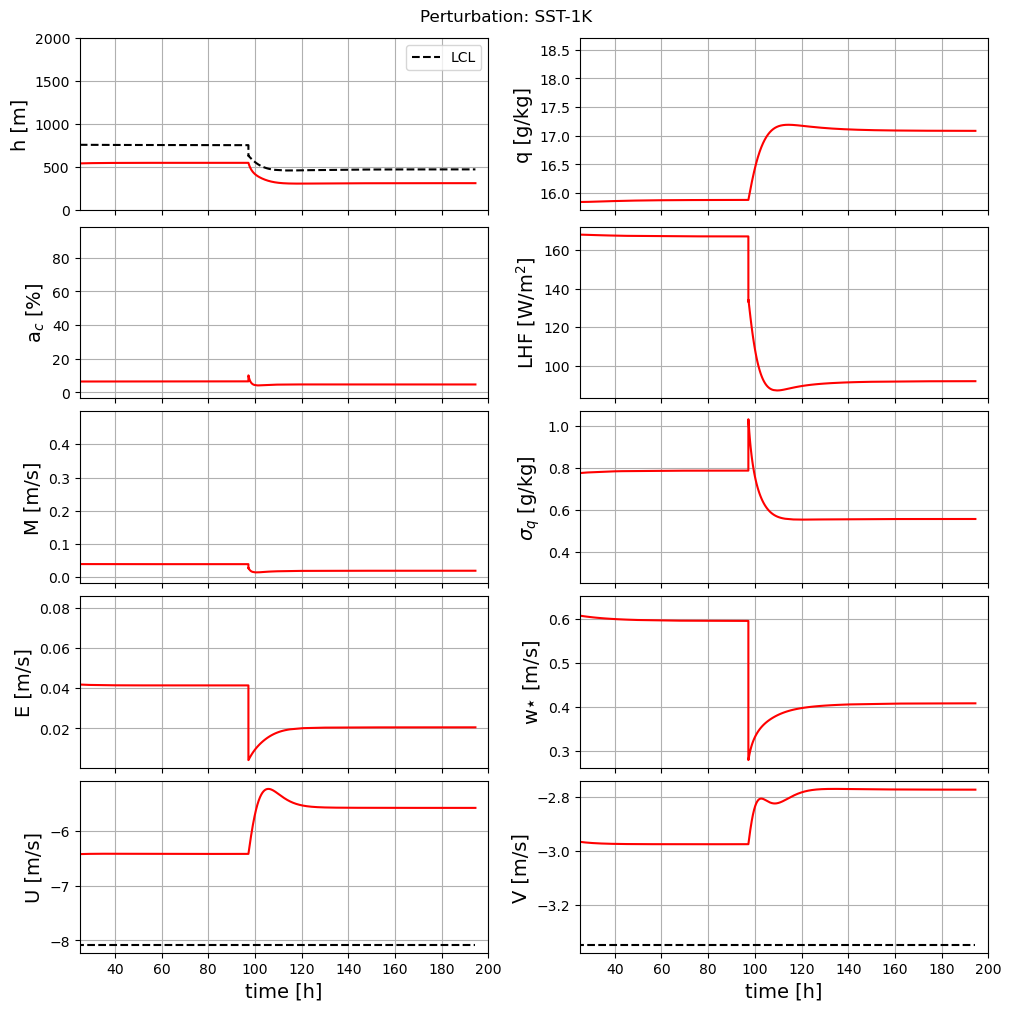

In [11]:
# Plots for a single run.
# h = sol_NS_eqPert.y[0]
# q = sol_NS_eqPert.y[1]
# th = sol_NS_eqPert.y[2]
# U = sol_NS_eqPert.y[3]
# V = sol_NS_eqPert.y[4]

h =  y_combined[0]
q =  y_combined[1]
th = y_combined[2]
U =  y_combined[3]
V =  y_combined[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final_NS = np.max(t_combined)
dt_NS = t_final_NS/3600/len(dict_ext_NS_eqPert['E_ext']) # [h]
time_ext_NS = np.arange(len(dict_ext_NS_eqPert['E_ext']))*dt_NS

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(dict_ext_NS_eqPert['area_c_ext'][-1]*100)+'%')
print('equilibrium w$^*$ = '+str(dict_ext_NS_eqPert['w_star_ext'][-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)
fig.suptitle('Perturbation: SST-1K')

# ax[0,0].plot(sol_N06.t/3600,h_CV,'k')
ax[0,0].plot(t_combined/3600,h,'r')
ax[0,0].plot(time_ext_NS, np.array(dict_ext_NS_eqPert['LCL_ext']),'--k', label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend()

# ax[0,1].plot(sol_N06.t/3600,q_CV*1e3,'k')
ax[0,1].plot(t_combined/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
# ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(t_combined/3600,sol_NS.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

# ax[1,0].plot(time_ext_N06,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['area_c_ext'])*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
# ax[1,0].set_ylim(0,20)
ax[1,0].grid()
# 
# ax[1,1].plot(time_ext_N06,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['LHF_ext']),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
# ax[1,1].set_ylim(0,500)
ax[1,1].grid()

# ax[2,0].plot(time_ext_N06,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['M_ext']),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
# ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

# ax[2,1].plot(time_ext_N06,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['sigma_q_ext'])*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
# ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

# ax[3,0].plot(time_ext_N06,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['E_ext']),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
# ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

# ax[3,1].plot(time_ext_N06,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext_NS,np.array(dict_ext_NS_eqPert['w_star_ext']),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
# ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].hlines(U_free,np.min(t_combined/3600),np.max(t_combined/3600),'k',linestyle='dashed')
ax[4,0].plot(t_combined/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].hlines(V_free,np.min(t_combined/3600),np.max(t_combined/3600),'k',linestyle='dashed')
ax[4,1].plot(t_combined/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(25,200)
ax[4,1].set_xlim(25,200)


filename = '/venus/tesi_ale/img_bulk/SST_minus1.pdf'
# plt.savefig(filename)
del filename

## run sensitivity tests on results from Neggers + Stevens also

In [41]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3                   # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67                    # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1                        # J/K/kg, dry air gas constant
SST = 300.4                       # K
ps = 1015                         # [hPa], surface pressure
ref_p = 1000                      # [hPa], reference pressure for the potential temperature
th_s = SST*(ref_p/ps)**(Rd/cpd)   # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3

y0 = [100,q_s - q_free, th_s-2, U_free+3, V_free]

# Input parameters
V = 8.75         # [m/s], large scale horizontal wind
SST = 300.4      # [K], sea surface temperature
D = 4.3e-6       # [1/s], large scale divergence
q_free = 4.0e-3  # [kg/kg] free tropospheric total mixing ratio
th_free = 308    # [K], free tropospheric liquid virtual potential temperature
ps = 1015        # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing values...
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

SST = 300.4                       # [K], sea surface temperature
D = 4.3e-6                        # [1/s], large scale divergence
q_free = 4.0e-3                   # [kg/kg] free tropospheric total mixing ratio
th_free = 308                     # [K], free tropospheric liquid virtual potential temperature
ps = 1015                         # [hPa], surface pressure
q_s = neggers_stevens.qsea(SST-273.15,ps)*1e-3


# ... and equilibrium values
h_N06 = 692               # m
q_N06 = 15                # g/kg 
a_c_N06 = 4.3             # %
w_star_N06 = 0.75         # m/s
M_N06 = 0.032             # m/s


dict_params = {
        'SST': {'values': np.arange(300,303,0.1), 'units': 'K'},# 'forcing_N06': SST_N06},
        'U_free': {'values': np.arange(U_free-5,U_free+5, 1), 'units': 'm/s'}, #'forcing_N06': V_N06},
        'V_free': {'values': np.arange(V_free-5,V_free+5, 0.5), 'units': 'm/s'}, # 'forcing_N06': V_N06},
        'D': {'values': np.arange(2.5,6.5,0.25)*1e-6, 'units': '1/s'}, # 'forcing_N06': D_N06},
        'q_free': {'values': np.arange(0.5e-3,4.0e-3,0.2e-3), 'units': 'kg/kg'}, # 'forcing_N06': q_free_N06},
        'th_free': {'values': np.arange(306,310, 0.2), 'units': 'K'}, # 'forcing_N06': th_free_N06},
        'ps': {'values': np.arange(1000,1030,5), 'units': 'hPa'}, # 'forcing_N06': ps_N06}
}

param_of_interest = 'U_free'
list_of_values = dict_params[param_of_interest]['values']
str_units = dict_params[param_of_interest]['units']

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
U_eq, V_eq = h_eq.copy(), h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
we_dyn_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()

for jj,U_free in enumerate(list_of_values):
    ii=0
    
    
    dict_ext = { 'area_c_ext':[], 'w_star_ext':[], 'M_ext':[], 'E_ext':[], 'LHF_ext':[], 'LHF_CC_ext':[], 'qs_ext':[], 'qsat_ext':[],\
                'SHF_ext':[], 'LCL_ext':[], 'sigma_q_ext':[], 'we_dyn_ext':[], 'b_flux_s_NoG_ext':[]}

    sol = solve_ivp(neggers_stevens.neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST,D,q_free,th_free,ps,f,U_free,V_free,we, dict_ext))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    LCL_eq[jj] = dict_ext['LCL_ext'][-1]       if len(dict_ext['LCL_ext']) is not 0 else 999
    
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    U_eq[jj] = sol.y[3][-1]
    V_eq[jj] = sol.y[4][-1]
    
    a_c_eq[jj] = dict_ext['area_c_ext'][-1]    if len(dict_ext['area_c_ext']) is not 0 else 999
    w_star_eq[jj] = dict_ext['w_star_ext'][-1] if len(dict_ext['w_star_ext']) is not 0 else 999
    we_dyn_eq[jj] = dict_ext['we_dyn_ext'][-1] if len(dict_ext['we_dyn_ext']) is not 0 else 999
    M_eq[jj] = dict_ext['M_ext'][-1]           if len(dict_ext['M_ext']) is not 0 else 999
    E_eq[jj] = dict_ext['E_ext'][-1]           if len(dict_ext['E_ext']) is not 0 else 999
    
    LHF_eq[jj] = dict_ext['LHF_ext'][-1]       if len(dict_ext['LHF_ext']) is not 0 else 999
    LHF_CC_eq[jj] = dict_ext['LHF_CC_ext'][-1] if len(dict_ext['LHF_CC_ext']) is not 0 else 999
    SHF_eq[jj] = dict_ext['SHF_ext'][-1]       if len(dict_ext['SHF_ext']) is not 0 else 999
    
    qs_eq[jj] = dict_ext['qs_ext'][-1]         if len(dict_ext['qs_ext']) is not 0 else 999
    qsat_eq[jj] = dict_ext['qsat_ext'][-1]     if len(dict_ext['qsat_ext']) is not 0 else 999
    
    
    
    if (np.round(100*(jj+1)/len(list_of_values)%10 == 0)):
        print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
        print('---------------------------------------')

10.0 percent
---------------------------------------
20.0 percent
---------------------------------------
30.0 percent
---------------------------------------
40.0 percent
---------------------------------------
50.0 percent
---------------------------------------
60.0 percent
---------------------------------------
70.0 percent
---------------------------------------
80.0 percent
---------------------------------------
90.0 percent
---------------------------------------
100.0 percent
---------------------------------------


In [24]:
qsat_eq

array([0.01764035, 0.0175371 , 0.01743151, 0.01732376, 0.01721402,
       0.01710244, 0.01698914, 0.01687425, 0.01675787, 0.01664011,
       0.01652105, 0.01640077, 0.01627934, 0.01615684, 0.01603333,
       0.01590886, 0.0157835 , 0.01565729, 0.01553027, 0.0154025 ,
       0.01527402, 0.01514487, 0.01501508, 0.01488469, 0.01475374,
       0.01462226, 0.01449027, 0.01435782, 0.01422492, 0.01409161])

/home/alessandro/miniconda3/envs/spec_tesi_clone/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb7cab62d50> has a label of '_line0' which cannot be automatically added to the legend.


Prandtl Number trend: 0.835169323970541  to  0.8027640404344646



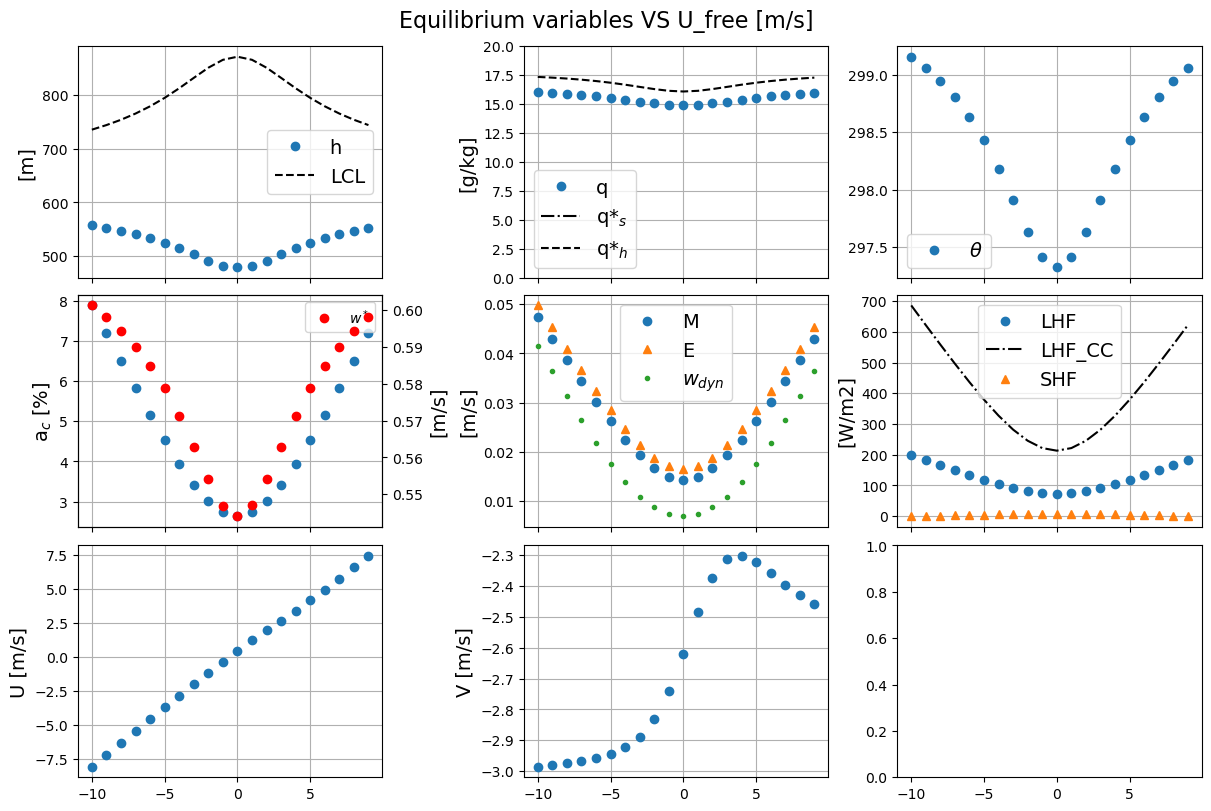

In [42]:
fig, ax = plt.subplots(3,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].set_ylabel('[m]',fontsize=14)
# ax[0,0].set_title('h and LCL', fontsize=12)
#ax[0,0].plot(dict_params[param_of_interest]['forcing_N06'],h_N06,'kv')
ax[0,0].legend(fontsize=14)

ax[0,1].plot(list_of_values,q_eq*1e3,'o',label='q')
ax[0,1].plot(list_of_values,qs_eq*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].set_ylabel('[g/kg]',fontsize=14)
#ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
#ax[0,1].plot(dict_params[param_of_interest]['forcing_N06'],q_N06,'kv')
ax[0,1].legend(fontsize=14)
ax[0,1].set_ylim(0,20)

ax[0,2].plot(list_of_values,th_eq,'o', label=r'$\theta$')
ax[0,2].grid()
# ax[0,2].set_ylabel('th [K]',fontsize=14)
#ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)
# ax[0,2].set_ylim(299.15, 299.30)


#####  components of Mass Flux  (M)
line1 = ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)

axino = ax[1,0].twinx()

line2 = axino.plot(list_of_values, w_star_eq, 'or', label=r'$w^*$')
axino.set_ylabel('[m/s]',fontsize=14)
ln = line1+line2
labs = [l.get_label() for l in ln]
ax[1, 0].legend(ln, labs, loc='best')






ax[1,1].plot(list_of_values,M_eq,'o',label='M')
ax[1,1].plot(list_of_values,E_eq,'^',label='E')
ax[1,1].plot(list_of_values,we_dyn_eq,'.',label=r'$w_{dyn}$')
ax[1,1].grid()
ax[1,1].set_ylabel('[m/s]',fontsize=14)
#ax[1,1].plot(dict_params[param_of_interest]['forcing_N06'],M_N06,'kv',label='N2006')
ax[1,1].legend(fontsize=14)

ax[1,2].plot(list_of_values,LHF_eq,'o',label='LHF')
ax[1,2].plot(list_of_values,LHF_CC_eq,'-.k',label='LHF_CC')
ax[1,2].plot(list_of_values,SHF_eq,'^',label='SHF')
ax[1,2].grid()
ax[1,2].set_ylabel('[W/m2]',fontsize=14)
ax[1,2].legend(fontsize=14)

ax[2,0].plot(list_of_values, U_eq, 'o', label='M')
ax[2,0].set_ylabel('U [m/s]',fontsize=14)
#ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(list_of_values, V_eq, 'o', label='M')
ax[2,1].set_ylabel('V [m/s]',fontsize=14)
#ax[2,1].set_ylim(0,0.10)
ax[2,1].grid()


fig.suptitle('Equilibrium variables VS '+param_of_interest+' ['+str_units+']',fontsize=16)

# figure_name = 'equilibrium_variables_set2_dependence_on_' + param_of_interest + '.png'
# plt.savefig(figure_name,bbox_inches='tight')


###########################################à


print(f'Prandtl Number trend: {(we_dyn_eq/E_eq)[0]}  to  {(we_dyn_eq/E_eq)[-1]}')
print()




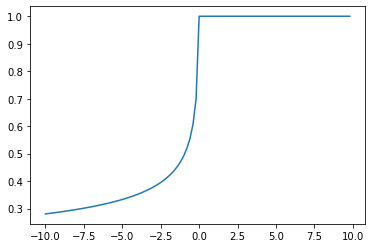

In [11]:
def prt_dyer74(zL):
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

zL = np.arange(-10,10,0.2)
Prt = np.zeros((len(zL),))
for ii,z in enumerate(zL):
    Prt[ii] = prt_dyer74(z)
    
plt.plot(zL,Prt)